In [1]:
import pandas as pd
import numpy as np
from dateutil.relativedelta import relativedelta
from matplotlib import pyplot as plt
from pandarallel import pandarallel
import seaborn as sns
# Initialization
pandarallel.initialize()


from dhs_preprocessing_functions import *
from dhs_modelling_functions import create_correlation_matrix

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.
/home/sven/pycharm/FoodSecurity/water_sven/


2024-05-24 15:30:07.398848: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64
2024-05-24 15:30:07.398870: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
input_dir_fs_pred = '/mnt/datadisk/data/FS_preds_country_ds/'
input_dir = "/mnt/datadisk/data/Projects/water/inputs/"
min_available_data_per_col = 20

gdp_pci_f = input_dir_fs_pred + 'GDP_CPI_weoapr2021all.csv'
fewsNet_f = f"{input_dir}fewsnet_gaul_adm2.csv"
out_f = input_dir + 'GDP_CPI_weoapr_preprocessed.csv'


In [3]:
print('Reading file:', gdp_pci_f)
# read with iso
try:
    gdp_pci_df = pd.read_csv(gdp_pci_f, encoding='utf-8', low_memory=False)
except UnicodeDecodeError:
    try:
        gdp_pci_df = pd.read_csv(gdp_pci_f, encoding='iso-8859-1', low_memory=False)
        print('iso-8859-1')
    except UnicodeDecodeError:
        try:
            gdp_pci_df = pd.read_csv(gdp_pci_f, encoding='cp1252', low_memory=False)
        except UnicodeDecodeError:
            gdp_pci_df = pd.read_csv(gdp_pci_f, encoding='utf-16', low_memory=False)
gdp_pci_df = gdp_pci_df.iloc[:-2, :]
gdp_pci_df

Reading file: /mnt/datadisk/data/FS_preds_country_ds/GDP_CPI_weoapr2021all.csv
iso-8859-1


WEO Country Code  ISO WEO Subject Code      Country  \
0                 512  AFG           NGDP_R  Afghanistan   
1                 512  AFG        NGDP_RPCH  Afghanistan   
2                 512  AFG             NGDP  Afghanistan   
3                 512  AFG            NGDPD  Afghanistan   
4                 512  AFG           PPPGDP  Afghanistan   
...               ...  ...              ...          ...   
8770              698  ZWE           GGXWDG     Zimbabwe   
8771              698  ZWE      GGXWDG_NGDP     Zimbabwe   
8772              698  ZWE          NGDP_FY     Zimbabwe   
8773              698  ZWE              BCA     Zimbabwe   
8774              698  ZWE        BCA_NGDPD     Zimbabwe   

                                     Subject Descriptor  \
0               Gross domestic product, constant prices   
1               Gross domestic product, constant prices   
2                Gross domestic product, current prices   
3                Gross domestic product, current prices   
4                Gross domestic product, current prices   
...                                                 ...   
8770                      General government gross debt   
8771                      General government gross debt   
8772  Gross domestic product corresponding to fiscal...   
8773                            Current account balance   
8774                            Current account balance   

                                          Subject Notes  \
0     Expressed in billions of national currency uni...   
1     Annual percentages of constant price GDP are y...   
2     Expressed in billions of national currency uni...   
3     Values are based upon GDP in national currency...   
4     These data form the basis for the country weig...   
...                                                 ...   
8770  Gross debt consists of all liabilities that re...   
8771  Gross debt consists of all liabilities that re...   
8772  Gross domestic product corresponding to fiscal...   
8773  Current account is all transactions other than...   
8774  Current account is all transactions other than...   

                                               Units     Scale  \
0                                  National currency  Billions   
1                                     Percent change       NaN   
2                                  National currency  Billions   
3                                       U.S. dollars  Billions   
4     Purchasing power parity; international dollars  Billions   
...                                              ...       ...   
8770                               National currency  Billions   
8771                                  Percent of GDP       NaN   
8772                               National currency  Billions   
8773                                    U.S. dollars  Billions   
8774                                  Percent of GDP       NaN   

                          Country/Series-specific Notes    1980  ...  \
0     Source: National Statistics Office Latest actu...     NaN  ...   
1     See notes for:  Gross domestic product, consta...     NaN  ...   
2     Source: National Statistics Office Latest actu...     NaN  ...   
3     See notes for:  Gross domestic product, curren...     NaN  ...   
4     See notes for:  Gross domestic product, curren...     NaN  ...   
...                                                 ...     ...  ...   
8770  Source: Ministry of Finance or Treasury Latest...     NaN  ...   
8771  See notes for:  General government gross debt ...     NaN  ...   
8772  Source: Ministry of Finance or Treasury Latest...     NaN  ...   
8773  Source: Reserve Bank of Zimbabwe and Ministry ...  -0.301  ...   
8774  See notes for:  Gross domestic product, curren...     NaN  ...   

          2018      2019      2020      2021      2022      2023      2024  \
0     1,270.22  1,319.90  1,253.91  1,304.06  1,363.06  1,424.40  1,481.50   
1        1.189     3.912        -5         4     4.5

In [4]:
def is_int(val):
    try:
        int(val)
        return True
    except ValueError:
        return False
    
def normalize_df(df, meta_cols, drop_below, cut_year_below=1995, cut_year_above=2022):
    print('4', df.isna().sum().sum(), df.shape)

    # convert columns to lower case
    df.columns = [c.lower() for c in df.columns]
    meta_cols = [c.lower() for c in meta_cols]
    # rename meta columns if necessary
    meta_cols_rename_d = {c: 'meta; ' + c for c in meta_cols if c[:5] != 'meta;'}
    if meta_cols_rename_d:
        df = df.rename(columns=meta_cols_rename_d)
        meta_cols = list(meta_cols_rename_d.values())
    print('5', df.isna().sum().sum(), df.shape)

    # convert columns to numeric
    df1 = df[[c for c in df.columns if c not in meta_cols]].apply(pd.to_numeric, errors='coerce')
    print('6', df.isna().sum().sum(), df.shape)
             
    df = pd.concat([df[meta_cols], df1], axis=1)
    if cut_year_below:
        df = df[(df['meta; year'] >= cut_year_below)]
    if cut_year_above:
        df = df[df['meta; year'] <= cut_year_above]
    if 'meta; country' in df.columns and not 'meta; adm0_name' in df.columns:
        df = df.rename(columns={'meta; country': 'meta; adm0_name'})
    replace_d = {'meta; adm0_name': {'Tanzania': 'United Republic of Tanzania',}}
    # check if items e.g. Tanzania are in the data and filter replace_d
    replace_d = {k: {kk: vv for kk, vv in v.items() if kk in df[k].values} for k, v in replace_d.items()}
    if replace_d and replace_d['meta; adm0_name']:
        df = df.replace(replace_d)
    print('7', df.isna().sum().sum(), df.shape)
    
    # drop below available data
    if drop_below:
        # df = df.dropna(thresh=drop_below, axis=1)
        nan_percentage = df.isna().mean()
        drop_cols = nan_percentage[nan_percentage > drop_below/100].index
        df = df.drop(drop_cols, axis=1)
    return df

def reverse_columns_with_attributes(df, attribute_cols, meta_cols, ds_str):
    print(df.columns)
    year_cols = [col for col in df.columns if is_int(col)]
    rest_cols = [col for col in df.columns if col not in year_cols + attribute_cols + meta_cols]
    print('Year columns:', len(year_cols), year_cols)
    print('attribute columns:', len(attribute_cols), attribute_cols)
    print('meta columns:', len(meta_cols), meta_cols)
    print('Rest columns:', len(rest_cols), rest_cols)
    df['attribute_col'] = df[attribute_cols].apply(lambda x: ' - '.join(str(i) for i in x if pd.notna(i)), axis=1)
    # df['attribute_col'] = df[attribute_cols].apply(lambda x: ': '.join(str(x)), axis=1)
    meta_df = df[['attribute_col'] + meta_cols + ['Country']].drop_duplicates()
    df = df.drop(columns=meta_cols)
    print('1', df.isna().sum().sum(), df.shape)
    # calculate all missing values
    

    # Melt the year columns into a single column
    df = df.melt(id_vars=['attribute_col'] + rest_cols, value_vars=year_cols, var_name='year', value_name='value')
    print('2.1', df.isna().sum().sum(), df.shape)

    df = df.pivot(index=['year'] + rest_cols, columns='attribute_col', values='value').reset_index()
    print('2', df.isna().sum().sum(), df.shape)

    data_cols = [col for col in df.columns if col not in ['year'] + rest_cols]
    # df.reset_index(inplace=True)
    df = df.rename(columns={c: f'meta; {c}' for c in rest_cols + ['year']})
    df = df.rename(columns={c: f'{ds_str}; {c}' for c in data_cols})
    if 'attribute_col' in df.columns:
        df = df.drop(columns=['attribute_col'])
    if 'index' in df.columns:
        df = df.drop(columns=['index'])
    print('3', df.isna().sum().sum(), df.shape)

    return df, meta_df

In [5]:
df, meta_df = reverse_columns_with_attributes(gdp_pci_df, ['Subject Descriptor', 'Units', 'Scale'], ['WEO Subject Code', 'Subject Notes', 'Country/Series-specific Notes', 'Estimates Start After'],
                                              'gdp_cpi_weoapr')

df = normalize_df(df, ['meta; ISO', 'meta; Country'], min_available_data_per_col, cut_year_above=2019)

# create date column from year using 12/31
df['meta; date'] = pd.to_datetime(df['meta; year'].astype(str) + '-12-31')
df

Index(['WEO Country Code', 'ISO', 'WEO Subject Code', 'Country',
       'Subject Descriptor', 'Subject Notes', 'Units', 'Scale',
       'Country/Series-specific Notes', '1980', '1981', '1982', '1983', '1984',
       '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993',
       '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002',
       '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011',
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       '2021', '2022', '2023', '2024', '2025', '2026',
       'Estimates Start After'],
      dtype='object')
Year columns: 47 ['1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987', '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995', '1996', '1997', '1998', '1999', '2000', '2001', '2002', '2003', '2004', '2005', '2006', '2007', '2008', '2009', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020', '2021', '2022', '20

meta; iso         meta; adm0_name  meta; year  meta; weo country code  \
2925       USA           United States        1995                     111   
2926       GBR          United Kingdom        1995                     112   
2927       AUT                 Austria        1995                     122   
2928       BEL                 Belgium        1995                     124   
2929       DNK                 Denmark        1995                     128   
...        ...                     ...         ...                     ...   
7795       MKD         North Macedonia        2019                     962   
7796       BIH  Bosnia and Herzegovina        2019                     963   
7797       POL                  Poland        2019                     964   
7798       UVK                  Kosovo        2019                     967   
7799       ROU                 Romania        2019                     968   

      gdp_cpi_weoapr; current account balance - percent of gdp  \
2925                                             -1.487          
2926                                             -0.676          
2927                                             -2.860          
2928                                              5.339          
2929                                              1.003          
...                                                 ...          
7795                                             -3.322          
7796                                             -3.088          
7797                                              0.492          
7798                                             -5.516          
7799                                             -4.697          

      gdp_cpi_weoapr; current account balance - u.s. dollars - billions  \
2925                                           -113.571                   
2926                                             -9.077                   
2927                                             -6.900                   
2928                                             15.391                   
2929                                              1.855                   
...                                                 ...                   
7795                                             -0.417                   
7796                                             -0.624                   
7797                                              2.931                   
7798                                             -0.439                   
7799                                            -11.729                   

      gdp_cpi_weoapr; general government gross debt - percent of gdp  \
2925                                                NaN                
2926                                             43.738                
2927                                             67.865                
2928                                            131.287                
2929                                             71.393                
...                                                 ...                
7795                                             40.640                
7796                                             32.350                
7797                                             45.684                
7798                                             17.570                
7799                                             36.823                

      gdp_cpi_weoapr; general government net lending/borrowing - national currency - billions  \
2925                                                NaN                                         
2926                                            -42.293                                         
2927                                            -10.843                                         
2928                                             -9.490                                         
2929                    

In [6]:
food_security_df = load_prepare_fs_df(fewsNet_f)
food_security_df = normalize_df(food_security_df, ['adm2_name', 'adm1_name', 'adm0_name', 'year', 'month'], False, cut_year_below=False, cut_year_above=False)
food_security_df['meta; date'] = pd.to_datetime(food_security_df['meta; year'].astype(str) + '-' + food_security_df['meta; month'].astype(str) + '-01') 
food_security_df

   OBJECTID  adm2_code            adm2_name  str2_year  exp2_year  adm1_code  \
0    1597.0    65431.0              Daguela     2000.0        0.0      873.0   
1    1599.0    65436.0             Dekakire     2000.0        0.0      873.0   
2    1602.0    65477.0                Gogmi     2000.0        0.0      873.0   
3    1605.0    65593.0                Melfi     2000.0        0.0      873.0   
4    1606.0    65606.0               Mokofi     2000.0        0.0      873.0   
5    1610.0    65621.0             Mousmare     2000.0        0.0      873.0   
6    1612.0    65668.0                Sorki     2000.0        0.0      873.0   
7    1642.0    65356.0             Am-timan     2000.0        0.0      881.0   
8    1643.0    65361.0           Autochtone     2000.0        0.0      881.0   
9    1644.0    65375.0  Barh-azoum-am-timan     2000.0        0.0      881.0   

  adm1_name        status disp_area  adm0_code  ... cov_end  report_mon  \
0     Guera  Member State        NO       50

meta; adm2_name meta; adm1_name                   meta; adm0_name  \
0              Daguela           Guera                              Chad   
1             Dekakire           Guera                              Chad   
2                Gogmi           Guera                              Chad   
3                Melfi           Guera                              Chad   
4               Mokofi           Guera                              Chad   
...                ...             ...                               ...   
104381      Lubumbashi         Katanga  Democratic Republic of the Congo   
104382         Kolwezi         Katanga  Democratic Republic of the Congo   
104383           Kindu         Maniema  Democratic Republic of the Congo   
104384         Butembo       Nord-Kivu  Democratic Republic of the Congo   
104385       Kisangani       Orientale  Democratic Republic of the Congo   

        meta; year  meta; month  ipc  ipc + food help meta; date  
0             2009            7  1.0              1.0 2009-07-01  
1             2009            7  1.0              1.0 2009-07-01  
2             2009            7  1.0              1.0 2009-07-01  
3             2009            7  1.0              1.0 2009-07-01  
4             2009            7  1.0              1.0 2009-07-01  
...            ...          ...  ...              ...        ...  
104381        2022            2  1.0              1.0 2022-02-01  
104382        2022            2  1.0              1.0 2022-02-01  
104383        2022            2  2.0              2.0 2022-02-01  
104384        2022            2  3.0              3.0 2022-02-01  
104385        2022            2  1.0              1.0 2022-02-01  

[104386 rows x 8 columns]

In [7]:
def unavialable_countries(adm0_1, adm0_2):
    print(set(adm0_1).difference(set(adm0_2)))
    
    
unavialable_countries(food_security_df['meta; adm0_name'].unique(), df['meta; adm0_name'].unique())
# food_security_df['adm0_name'].unique()

{'Abyei', "Hala'ib triangle", 'Ilemi triangle'}


In [8]:
def aggregate_ipc_adm0(row, food_security_df, start_delta, end_delta, y_m_indicator, group_by_col='meta; adm0_name'):
    # Create datetime objects for the start and end dates
    in_date = row['meta; date']
    if y_m_indicator == 'm':
        start_date = in_date + relativedelta(months=start_delta)
        end_date = in_date + relativedelta(months=end_delta)
    elif y_m_indicator == 'y':
        start_date = in_date + relativedelta(years=start_delta)
        end_date = in_date + relativedelta(years=end_delta)
    else:
        raise ValueError(f"y_m_indicator should be 'm' or 'y', not {y_m_indicator}")


    
    df_time_span = food_security_df[(food_security_df['meta; date'] >= start_date) & (food_security_df['meta; date'] < end_date) & 
                                    (food_security_df[group_by_col] == row[group_by_col])]


    row[f'fs; ipc: {start_delta}-{end_delta}{y_m_indicator}: mean'] = df_time_span['ipc'].mean()
    # row[f'fs; ipc: {start_delta}-{end_delta}{y_m_indicator}: max'] = df_time_span['ipc'].max()
    # row[f'fs; ipc: {start_delta}-{end_delta}{y_m_indicator}: min'] = df_time_span['ipc'].min()
    # row[f'fs; ipc: {start_delta}-{end_delta}{y_m_indicator}: median'] = round(df_time_span['ipc'].median(), 0)

    # row[f'fs; ipc + fh: {start_delta}-{end_delta}{y_m_indicator}: mean'] = df_time_span['ipc + food help'].mean()
    # row[f'fs; ipc + fh: {start_delta}-{end_delta}{y_m_indicator}: max'] = df_time_span['ipc + food help'].max()
    # row[f'fs; ipc + fh: {start_delta}-{end_delta}{y_m_indicator}: min'] = df_time_span['ipc + food help'].min()
    # row[f'fs; ipc + fh: {start_delta}-{end_delta}{y_m_indicator}: median'] = round(df_time_span['ipc + food help'].median(), 0)

    return row

print(food_security_df.shape)
print(df.shape)
print('meta; date' in df.columns)

for start_delta, end_delta, m_y_ind in [(-1, 0, 'y'), (0, 6, 'm'), (0, 2, 'y'), (2, 6, 'y'), (6, 12, 'y'), (12, 20, 'y')]:
    df = df.parallel_apply(aggregate_ipc_adm0, axis=1, food_security_df=food_security_df, start_delta=start_delta, 
                                            end_delta=end_delta, y_m_indicator=m_y_ind, group_by_col='meta; adm0_name')

# df = df.reset_index()
df


(104386, 8)
(4875, 31)
True


meta; iso         meta; adm0_name  meta; year  meta; weo country code  \
2925       USA           United States        1995                     111   
2926       GBR          United Kingdom        1995                     112   
2927       AUT                 Austria        1995                     122   
2928       BEL                 Belgium        1995                     124   
2929       DNK                 Denmark        1995                     128   
...        ...                     ...         ...                     ...   
7795       MKD         North Macedonia        2019                     962   
7796       BIH  Bosnia and Herzegovina        2019                     963   
7797       POL                  Poland        2019                     964   
7798       UVK                  Kosovo        2019                     967   
7799       ROU                 Romania        2019                     968   

      gdp_cpi_weoapr; current account balance - percent of gdp  \
2925                                             -1.487          
2926                                             -0.676          
2927                                             -2.860          
2928                                              5.339          
2929                                              1.003          
...                                                 ...          
7795                                             -3.322          
7796                                             -3.088          
7797                                              0.492          
7798                                             -5.516          
7799                                             -4.697          

      gdp_cpi_weoapr; current account balance - u.s. dollars - billions  \
2925                                           -113.571                   
2926                                             -9.077                   
2927                                             -6.900                   
2928                                             15.391                   
2929                                              1.855                   
...                                                 ...                   
7795                                             -0.417                   
7796                                             -0.624                   
7797                                              2.931                   
7798                                             -0.439                   
7799                                            -11.729                   

      gdp_cpi_weoapr; general government gross debt - percent of gdp  \
2925                                                NaN                
2926                                             43.738                
2927                                             67.865                
2928                                            131.287                
2929                                             71.393                
...                                                 ...                
7795                                             40.640                
7796                                             32.350                
7797                                             45.684                
7798                                             17.570                
7799                                             36.823                

      gdp_cpi_weoapr; general government net lending/borrowing - national currency - billions  \
2925                                                NaN                                         
2926                                            -42.293                                         
2927                                            -10.843                                         
2928                                             -9.490                                         
2929                    

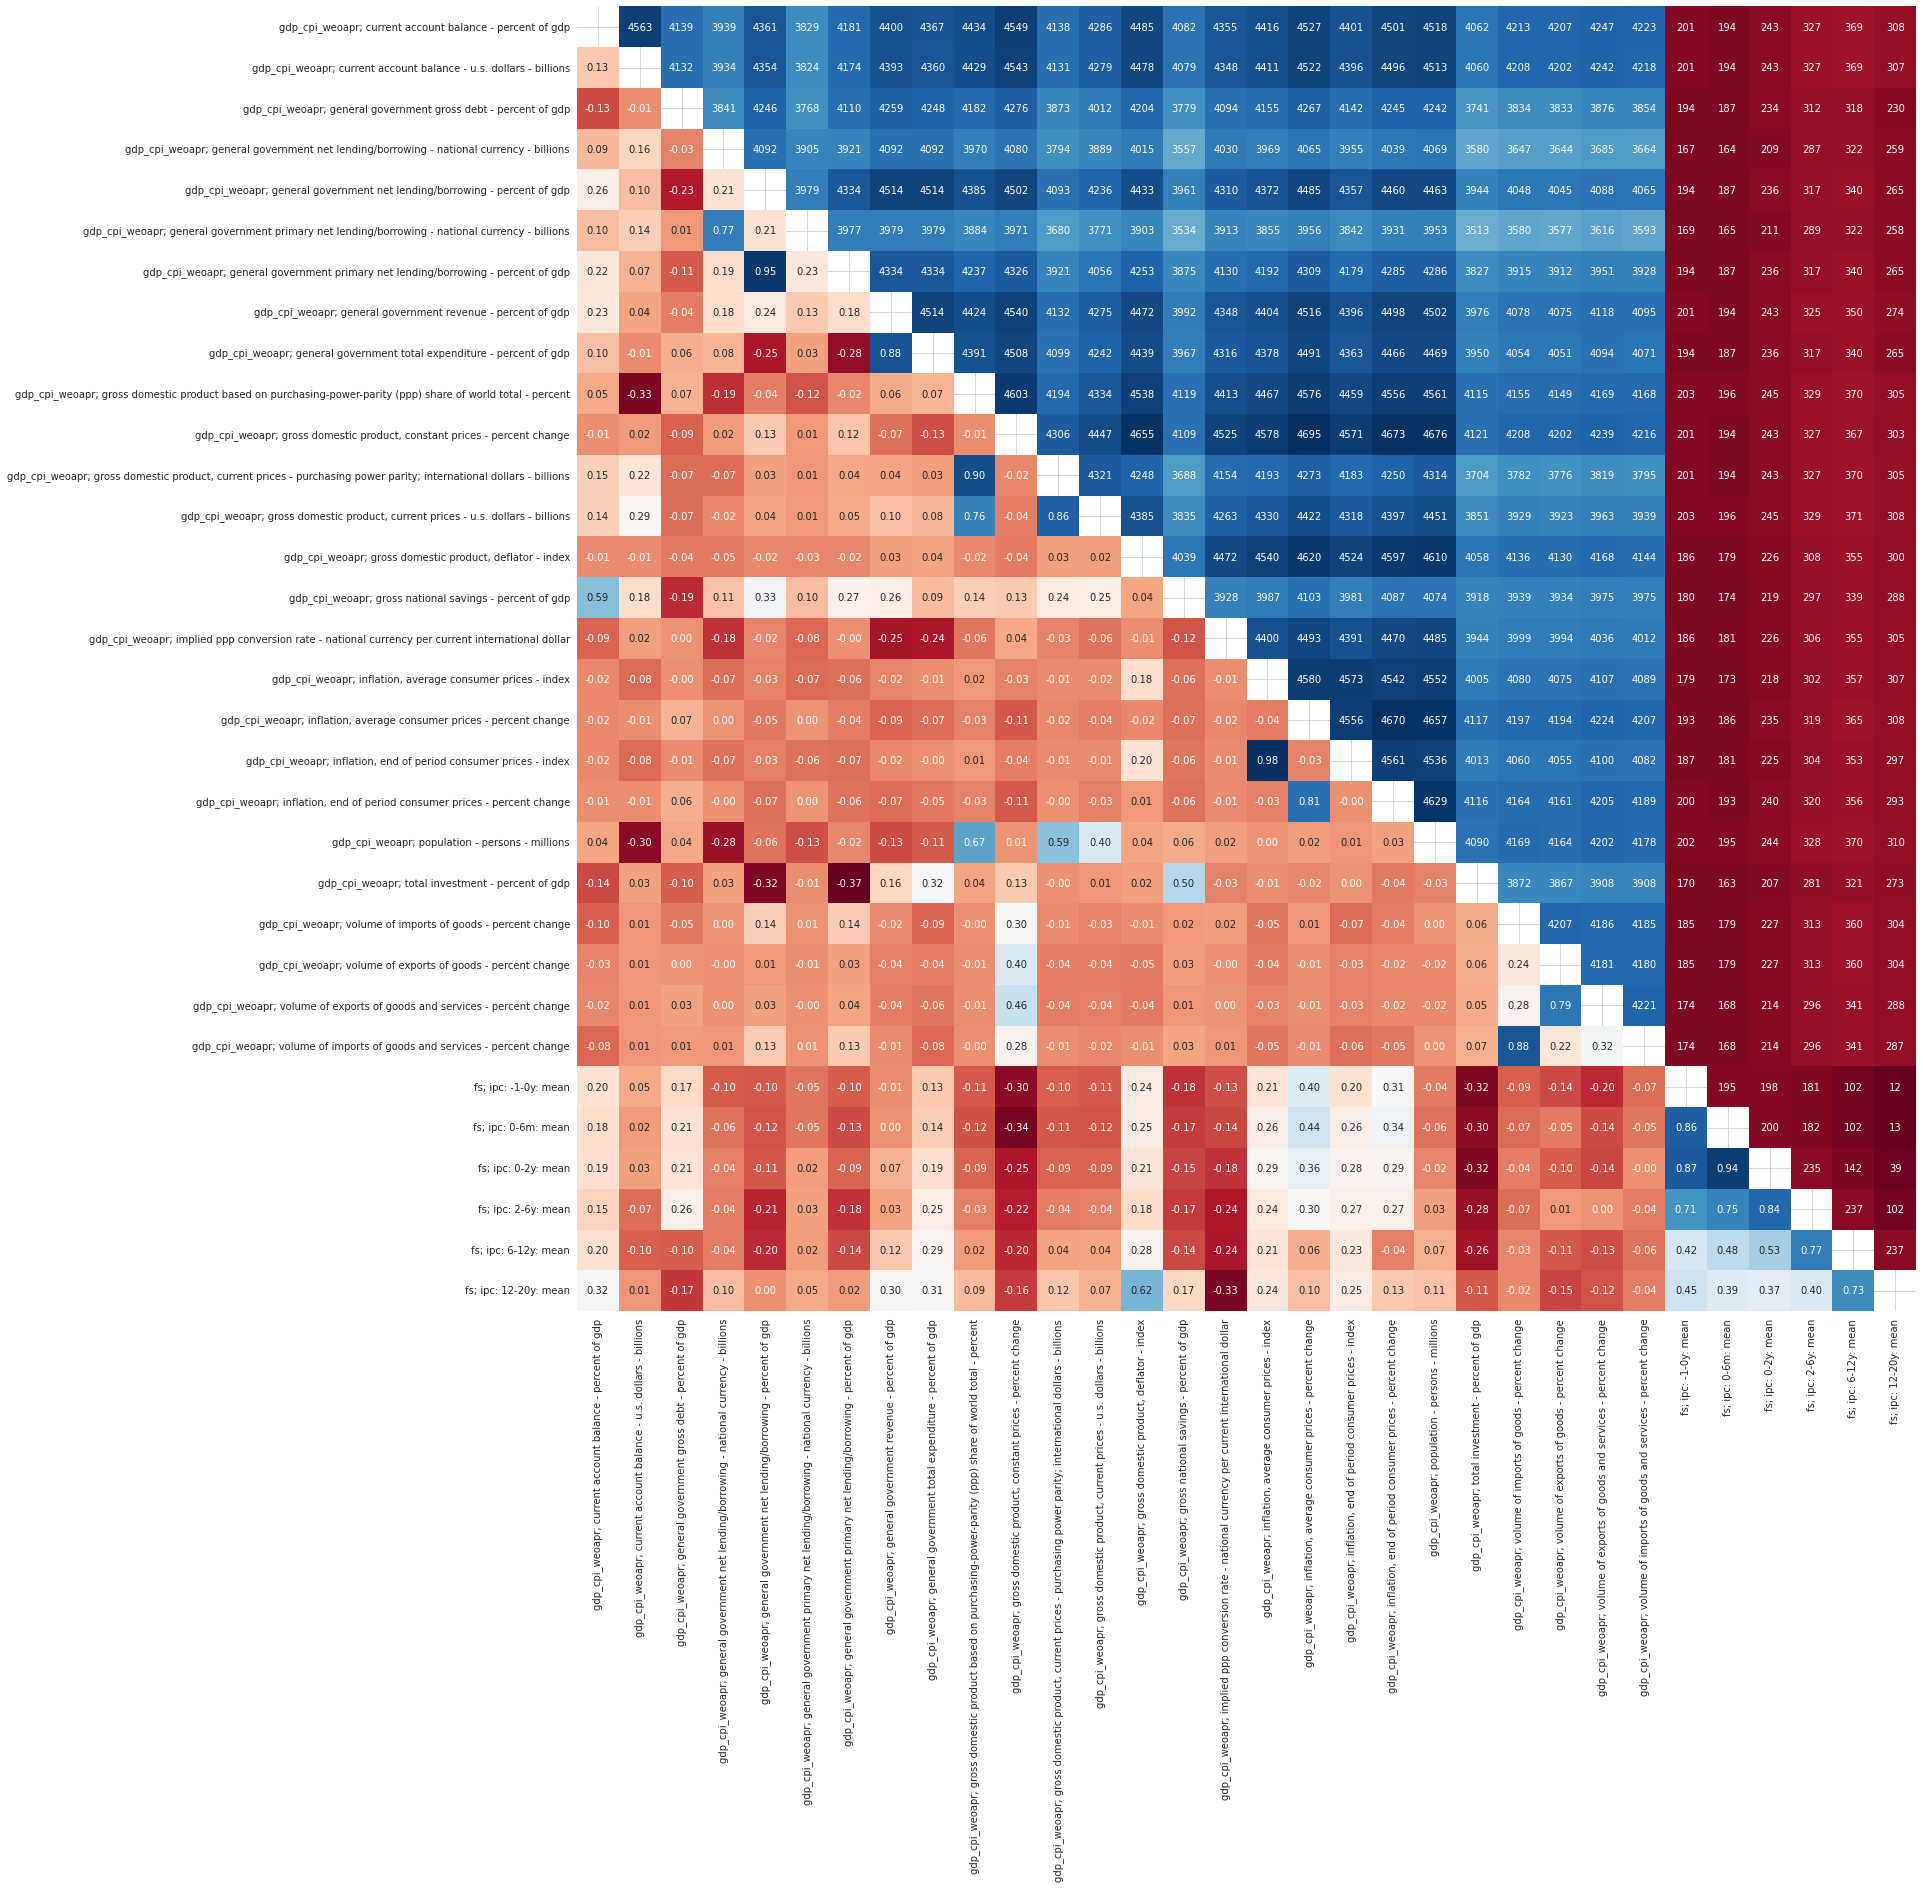

In [9]:
cols_to_use = [c for c in df.columns if not 'meta;' in c]
create_correlation_matrix(df[cols_to_use])

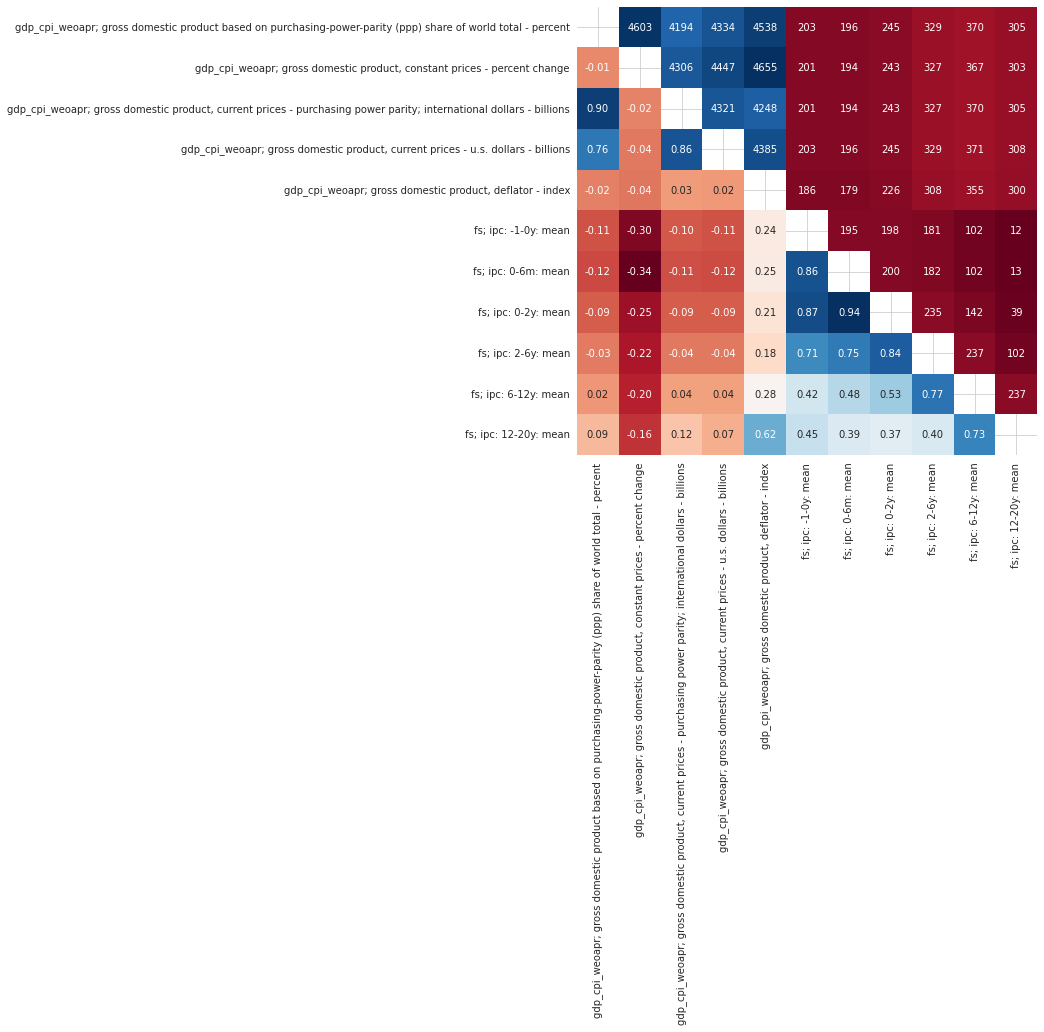

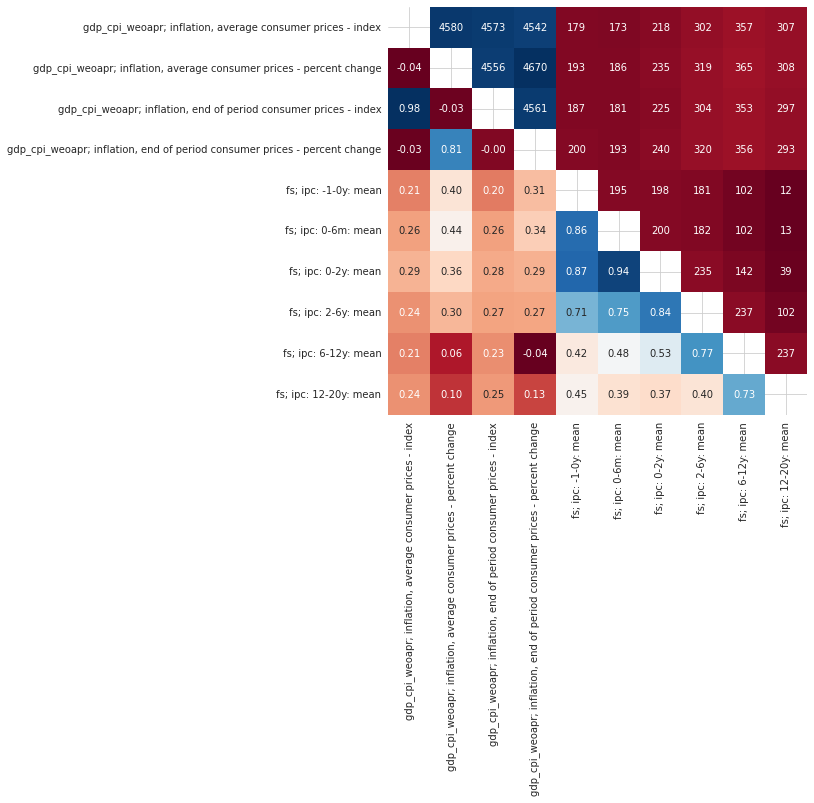

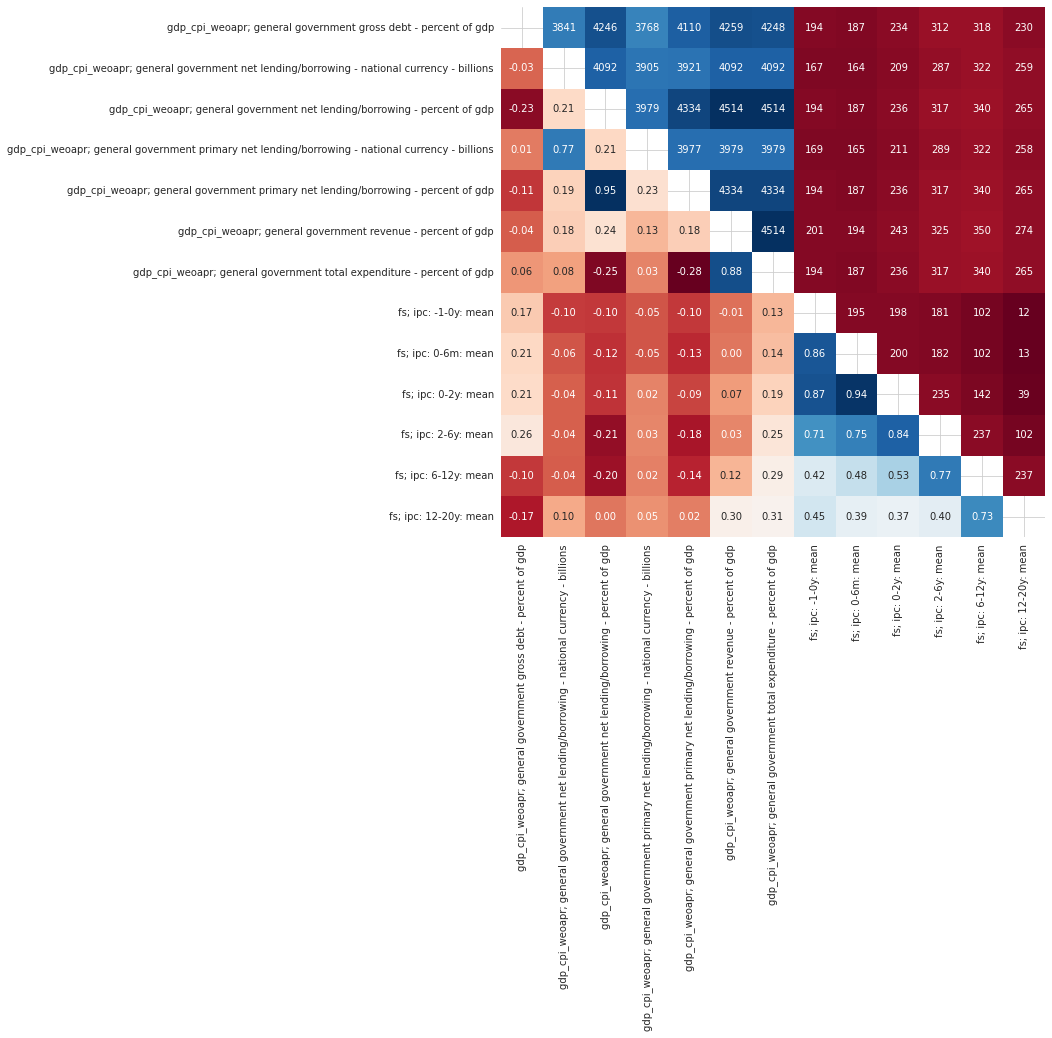

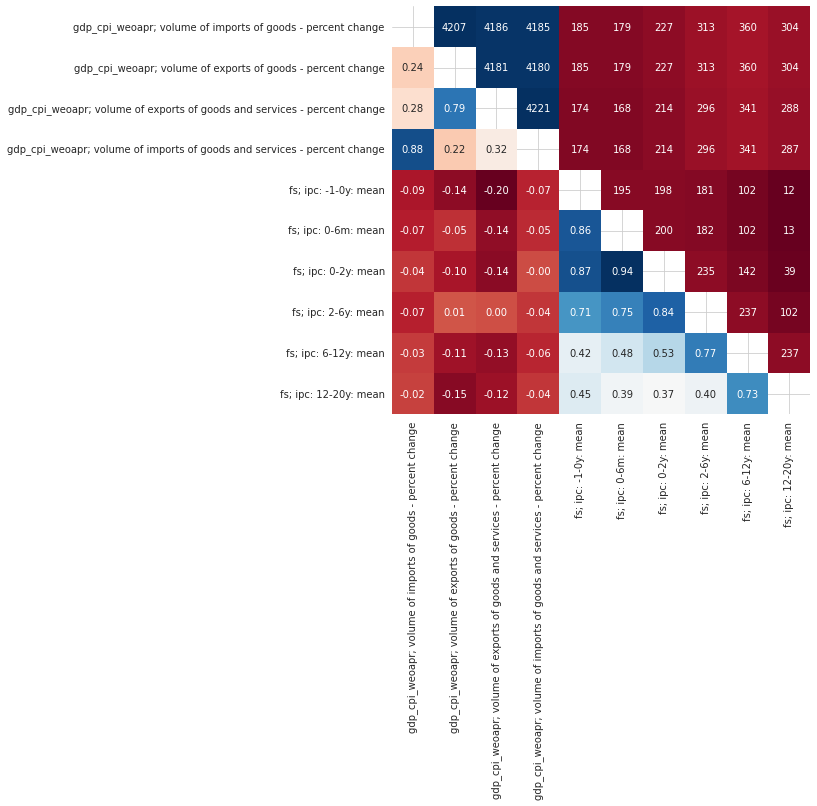

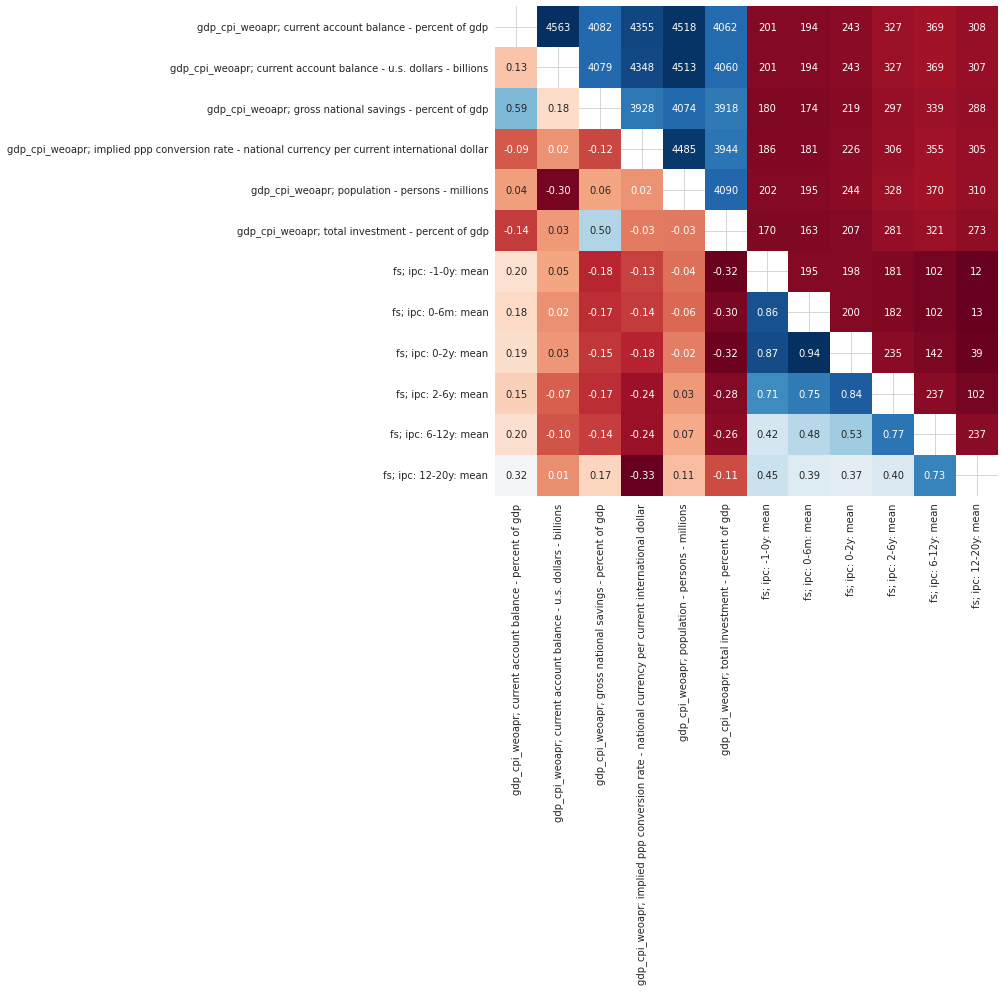

In [10]:
key_words = ['gross domestic product', 'inflation', 'government', 'volume']
fs_cols = [col for col in df.columns if 'fs;' in col and not '0-1y' in col and not '20-30y' in col]
for kw in key_words:
    cols_to_use2 = [col for col in cols_to_use if kw in col]
    create_correlation_matrix(df[cols_to_use2 + fs_cols])
rest_cols = [col for col in cols_to_use if not any([kw in col for kw in key_words])]
create_correlation_matrix(df[rest_cols].select_dtypes(include=[np.number]))


In [11]:
def aggregate_values(row, df, years, group_by_col='meta; adm0_name'):
    in_year = row['meta; year']
    
    for nr, year in enumerate(years):
        endyear = in_year
        startyear = in_year - year
        if nr > 0:
            previous_time_span_year = in_year - years[nr-1]
        else:
            previous_time_span_year = startyear
        # time_delta = in_year - startyear
        
        # print(startyear, previous_time_span_year, endyear, in_year, year)
        df_time_span = df[(df['meta; year'] > startyear) & (df['meta; year'] <= endyear) & 
                                        (df[group_by_col] == row[group_by_col])]
        sub_time_span = df_time_span[(df_time_span['meta; year'] > startyear) & (df_time_span['meta; year'] <= previous_time_span_year)]
        # print(len(df_time_span), len(sub_time_span))
        for column in df_time_span.columns:
            if column not in ['meta; year', group_by_col]:
                col_str = column
                if ' - percent change' in column:
                    col_str = col_str.replace(' - percent change', '')
                # only calculate if there is enough data in the sub_time_span (at least 2 years)
                if (year == 1) or (year == 2 and sub_time_span[column].count() >= 1) or (sub_time_span[column].count() >= 2): 
                    row[f'{col_str}: mean perc. change {year:02d} years'] = df_time_span[column].mean()
                else:
                    row[f'{col_str}: mean perc. change {year:02d} years'] = np.nan
    return row


def wrap_aggregate_values(df_in, cols_to_use, calculate_perc_change_first=False):
    df = df_in[cols_to_use]
    if calculate_perc_change_first:
        df = df.set_index(['meta; adm0_name', 'meta; year'])

        # Sort the DataFrame by the index
        df = df.sort_index()
        # Calculate the percentage change for each attribute
        df = df.groupby(level=0).pct_change()
        # df_pct_change = df_pct_change[df_pct_change['meta; adm0_name'] == 'Mozambique']

        # Reset the index
        df = df.reset_index()
        
    years = [1, 2, 5, 10, 15]
    df = df.parallel_apply(lambda row: aggregate_values(row, df, years), axis=1)
        
    df = pd.merge(df_in, df[[c for c in df.columns if ': mean perc. change' in c] + ['meta; adm0_name', 'meta; year']], on=['meta; adm0_name', 'meta; year'], how='left')
    
    df_fs = df[[c for c in df.columns if 'fs;' in c]]
    dfm = df[[c for c in df.columns if 'meta;' in c]]
    dfn = df[[c for c in df.columns if not 'fs;' in c and not 'meta;' in c]]
    # alphabetically sort the columns
    dfn = dfn.reindex(sorted(dfn.columns), axis=1)
    df = pd.concat([dfm, dfn, df_fs], axis=1)
    return df
    

In [12]:
cols_to_use_change = [col for col in cols_to_use if not 'national currency' in col and not 'fs;' in col]
# mean percentage change per x (1,2,5,10,15) years aggregated/dis_aggregated
perc_gdp_cols = [col for col in cols_to_use_change if 'percent of gdp' in col]
# mean change x (1,2,5,10,15) years aggregated/dis_aggregated
perc_cols = [col for col in cols_to_use_change if 'percent change' in col and not 'percent of gdp' in col]
# drop gdp_cpi_weoapr; gross domestic product based on purchasing-power-parity (ppp) share of world total: percent: nan ?
# mean percentage changes
rest_cols = list(set(cols_to_use_change).difference(set(perc_gdp_cols + perc_cols)))
# print(cols_to_use)
# print(cols_to_use_change)
print(len(perc_gdp_cols), perc_gdp_cols)
print(len(perc_cols), perc_cols)
print(len(rest_cols), rest_cols)
for cols in [perc_gdp_cols, perc_cols, rest_cols]:
    print(len(cols))
    for c in cols:
        print(c)


df1 = wrap_aggregate_values(df, ['meta; adm0_name', 'meta; year'] + perc_cols)
df2 = wrap_aggregate_values(df1, ['meta; adm0_name', 'meta; year'] + perc_gdp_cols + rest_cols, calculate_perc_change_first=True)
df2

8 ['gdp_cpi_weoapr; current account balance - percent of gdp', 'gdp_cpi_weoapr; general government gross debt - percent of gdp', 'gdp_cpi_weoapr; general government net lending/borrowing - percent of gdp', 'gdp_cpi_weoapr; general government primary net lending/borrowing - percent of gdp', 'gdp_cpi_weoapr; general government revenue - percent of gdp', 'gdp_cpi_weoapr; general government total expenditure - percent of gdp', 'gdp_cpi_weoapr; gross national savings - percent of gdp', 'gdp_cpi_weoapr; total investment - percent of gdp']
7 ['gdp_cpi_weoapr; gross domestic product, constant prices - percent change', 'gdp_cpi_weoapr; inflation, average consumer prices - percent change', 'gdp_cpi_weoapr; inflation, end of period consumer prices - percent change', 'gdp_cpi_weoapr; volume of imports of goods - percent change', 'gdp_cpi_weoapr; volume of exports of goods - percent change', 'gdp_cpi_weoapr; volume of exports of goods and services - percent change', 'gdp_cpi_weoapr; volume of impor

meta; iso         meta; adm0_name  meta; year  meta; weo country code  \
0          USA           United States        1995                     111   
1          GBR          United Kingdom        1995                     112   
2          AUT                 Austria        1995                     122   
3          BEL                 Belgium        1995                     124   
4          DNK                 Denmark        1995                     128   
...        ...                     ...         ...                     ...   
4870       MKD         North Macedonia        2019                     962   
4871       BIH  Bosnia and Herzegovina        2019                     963   
4872       POL                  Poland        2019                     964   
4873       UVK                  Kosovo        2019                     967   
4874       ROU                 Romania        2019                     968   

     meta; date  gdp_cpi_weoapr; current account balance - percent of gdp  \
0    1995-12-31                                             -1.487          
1    1995-12-31                                             -0.676          
2    1995-12-31                                             -2.860          
3    1995-12-31                                              5.339          
4    1995-12-31                                              1.003          
...         ...                                                ...          
4870 2019-12-31                                             -3.322          
4871 2019-12-31                                             -3.088          
4872 2019-12-31                                              0.492          
4873 2019-12-31                                             -5.516          
4874 2019-12-31                                             -4.697          

      gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 01 years  \
0                                                   NaN                                      
1                                                   NaN                                      
2                                                   NaN                                      
3                                                   NaN                                      
4                                                   NaN                                      
...                                                 ...                                      
4870                                          49.333333                                      
4871                                          -0.078759                                      
4872                                          -1.383775                                      
4873                                          -0.270853                                      
4874                                           0.071396                                      

      gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 02 years  \
0                                                   NaN                                      
1                                                   NaN                                      
2                                                   NaN                                      
3                                                   NaN                                      
4                                                   NaN                                      
...                                                 ...                                      
4870                                          24.198155                                      
4871                                          -0.193384                                      
4872                                           0.531231                                      
4873                                           0.060526                   

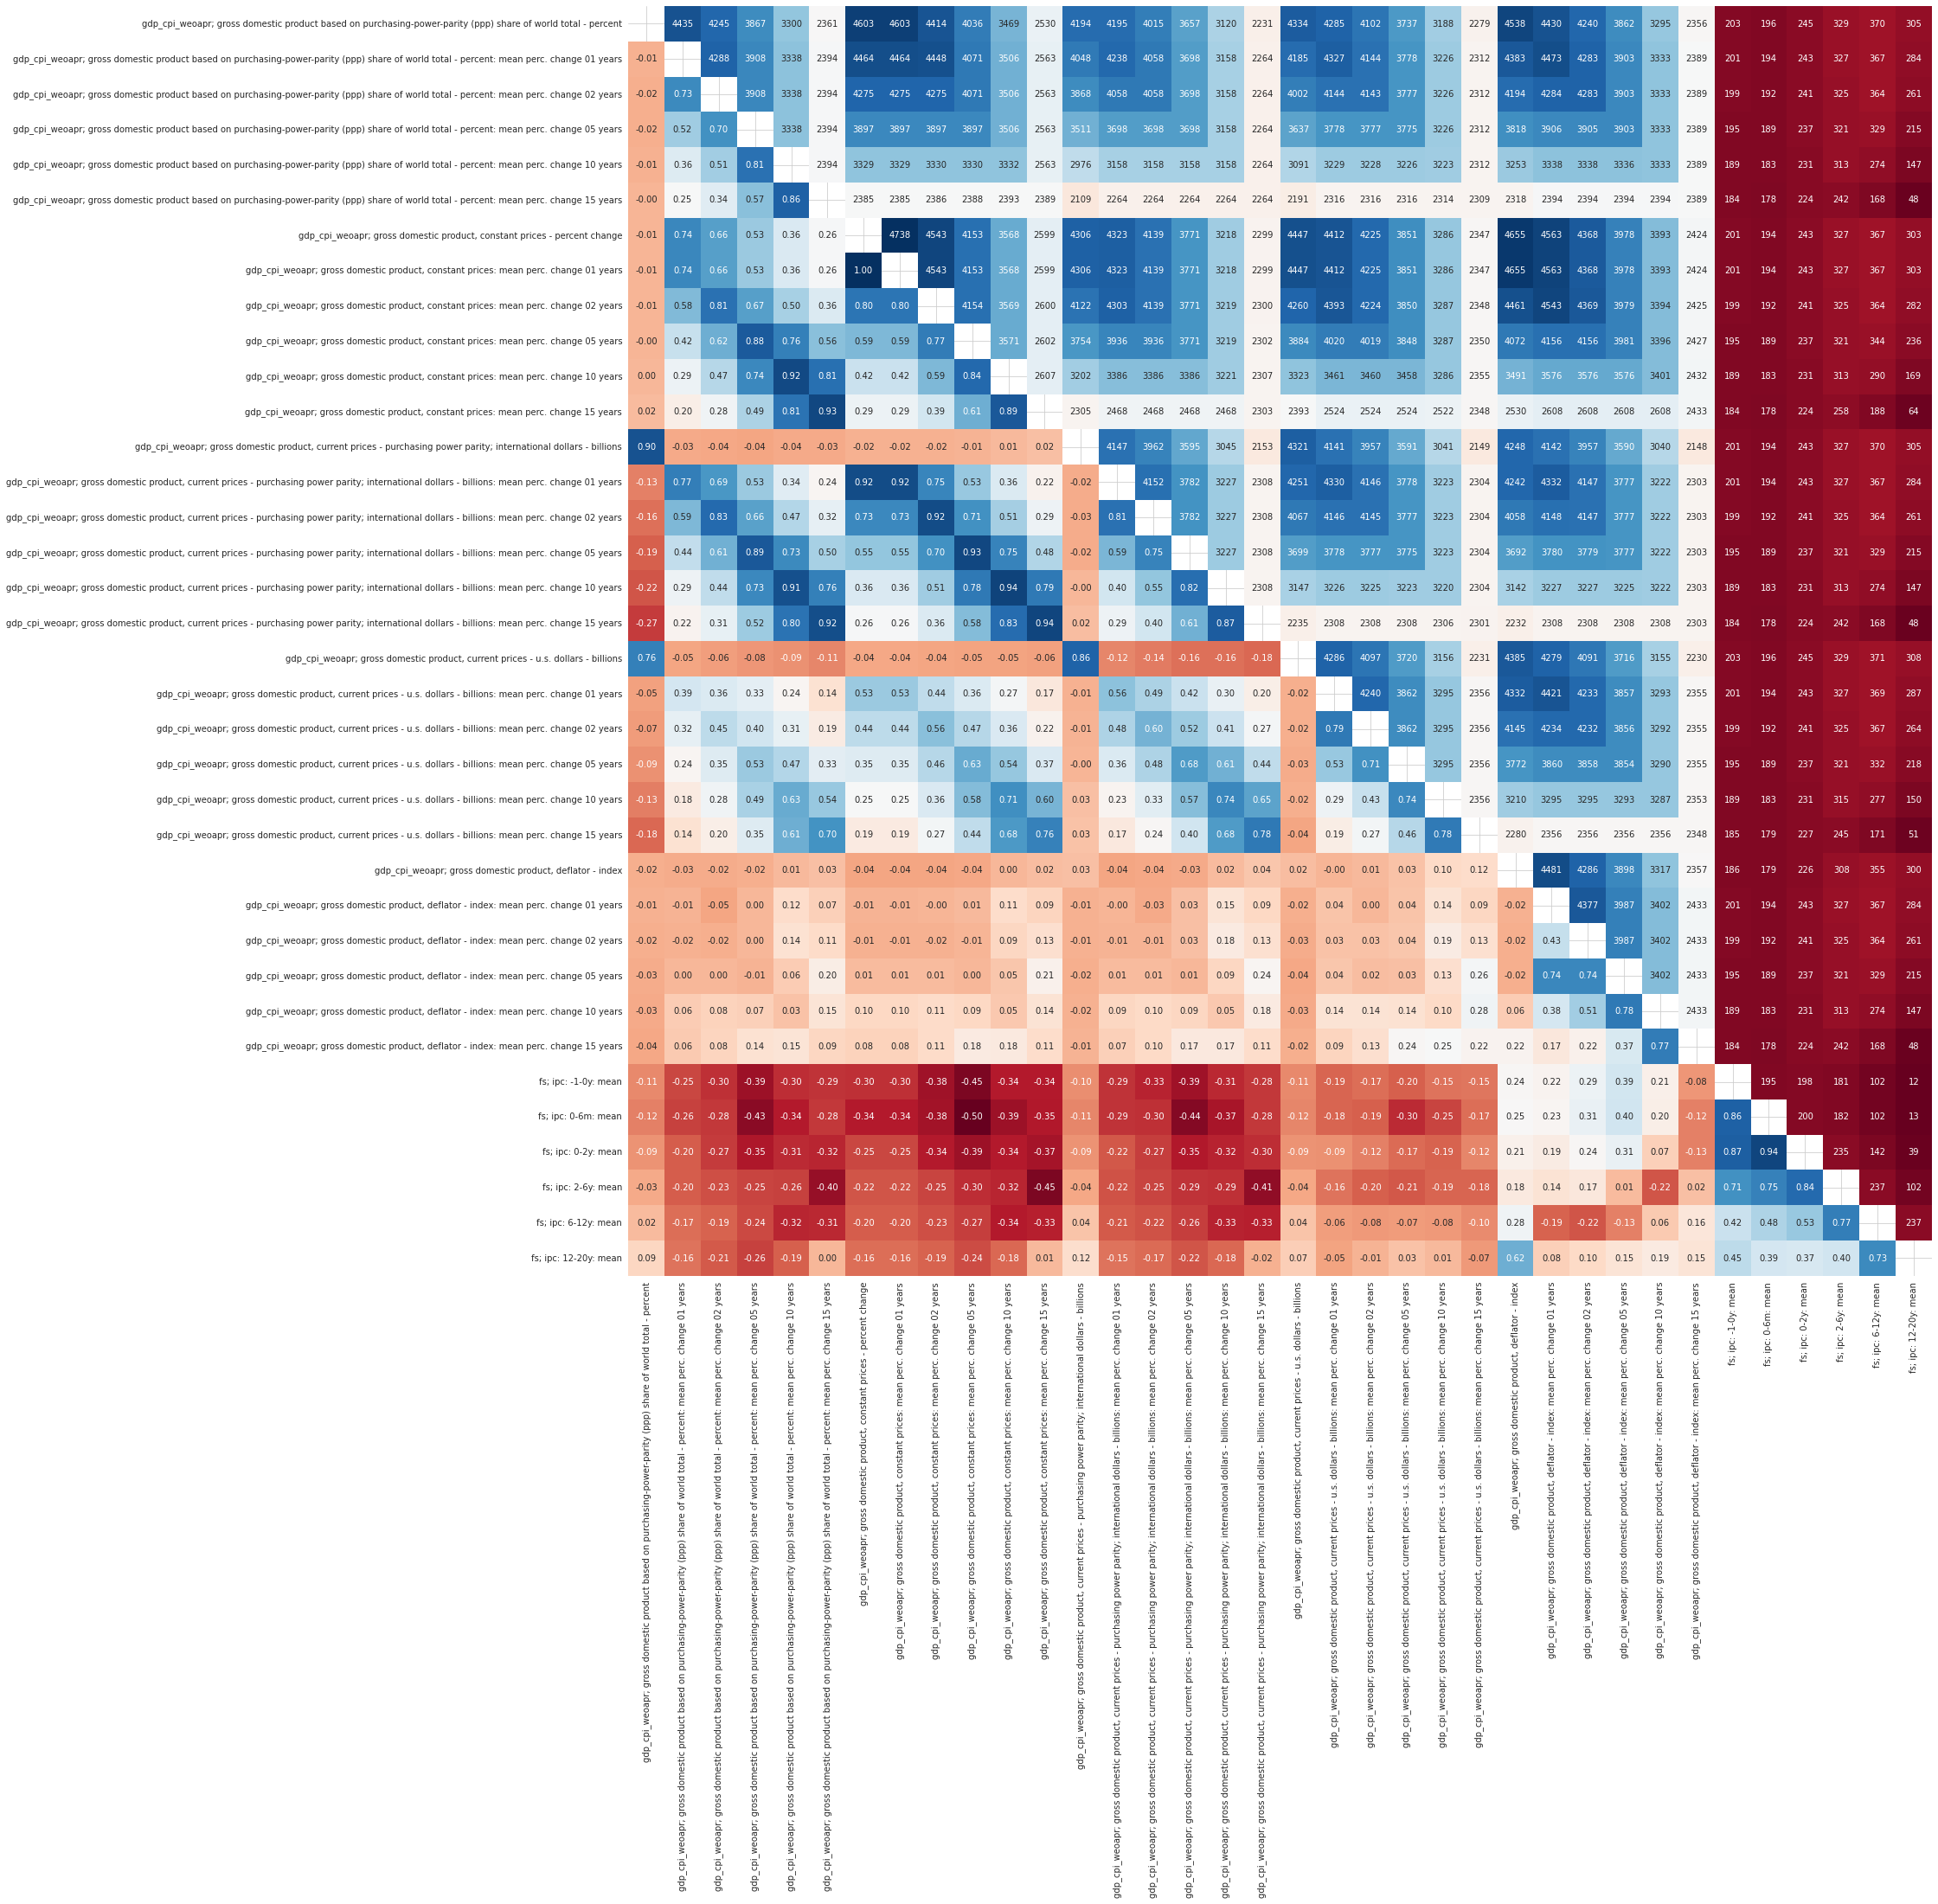

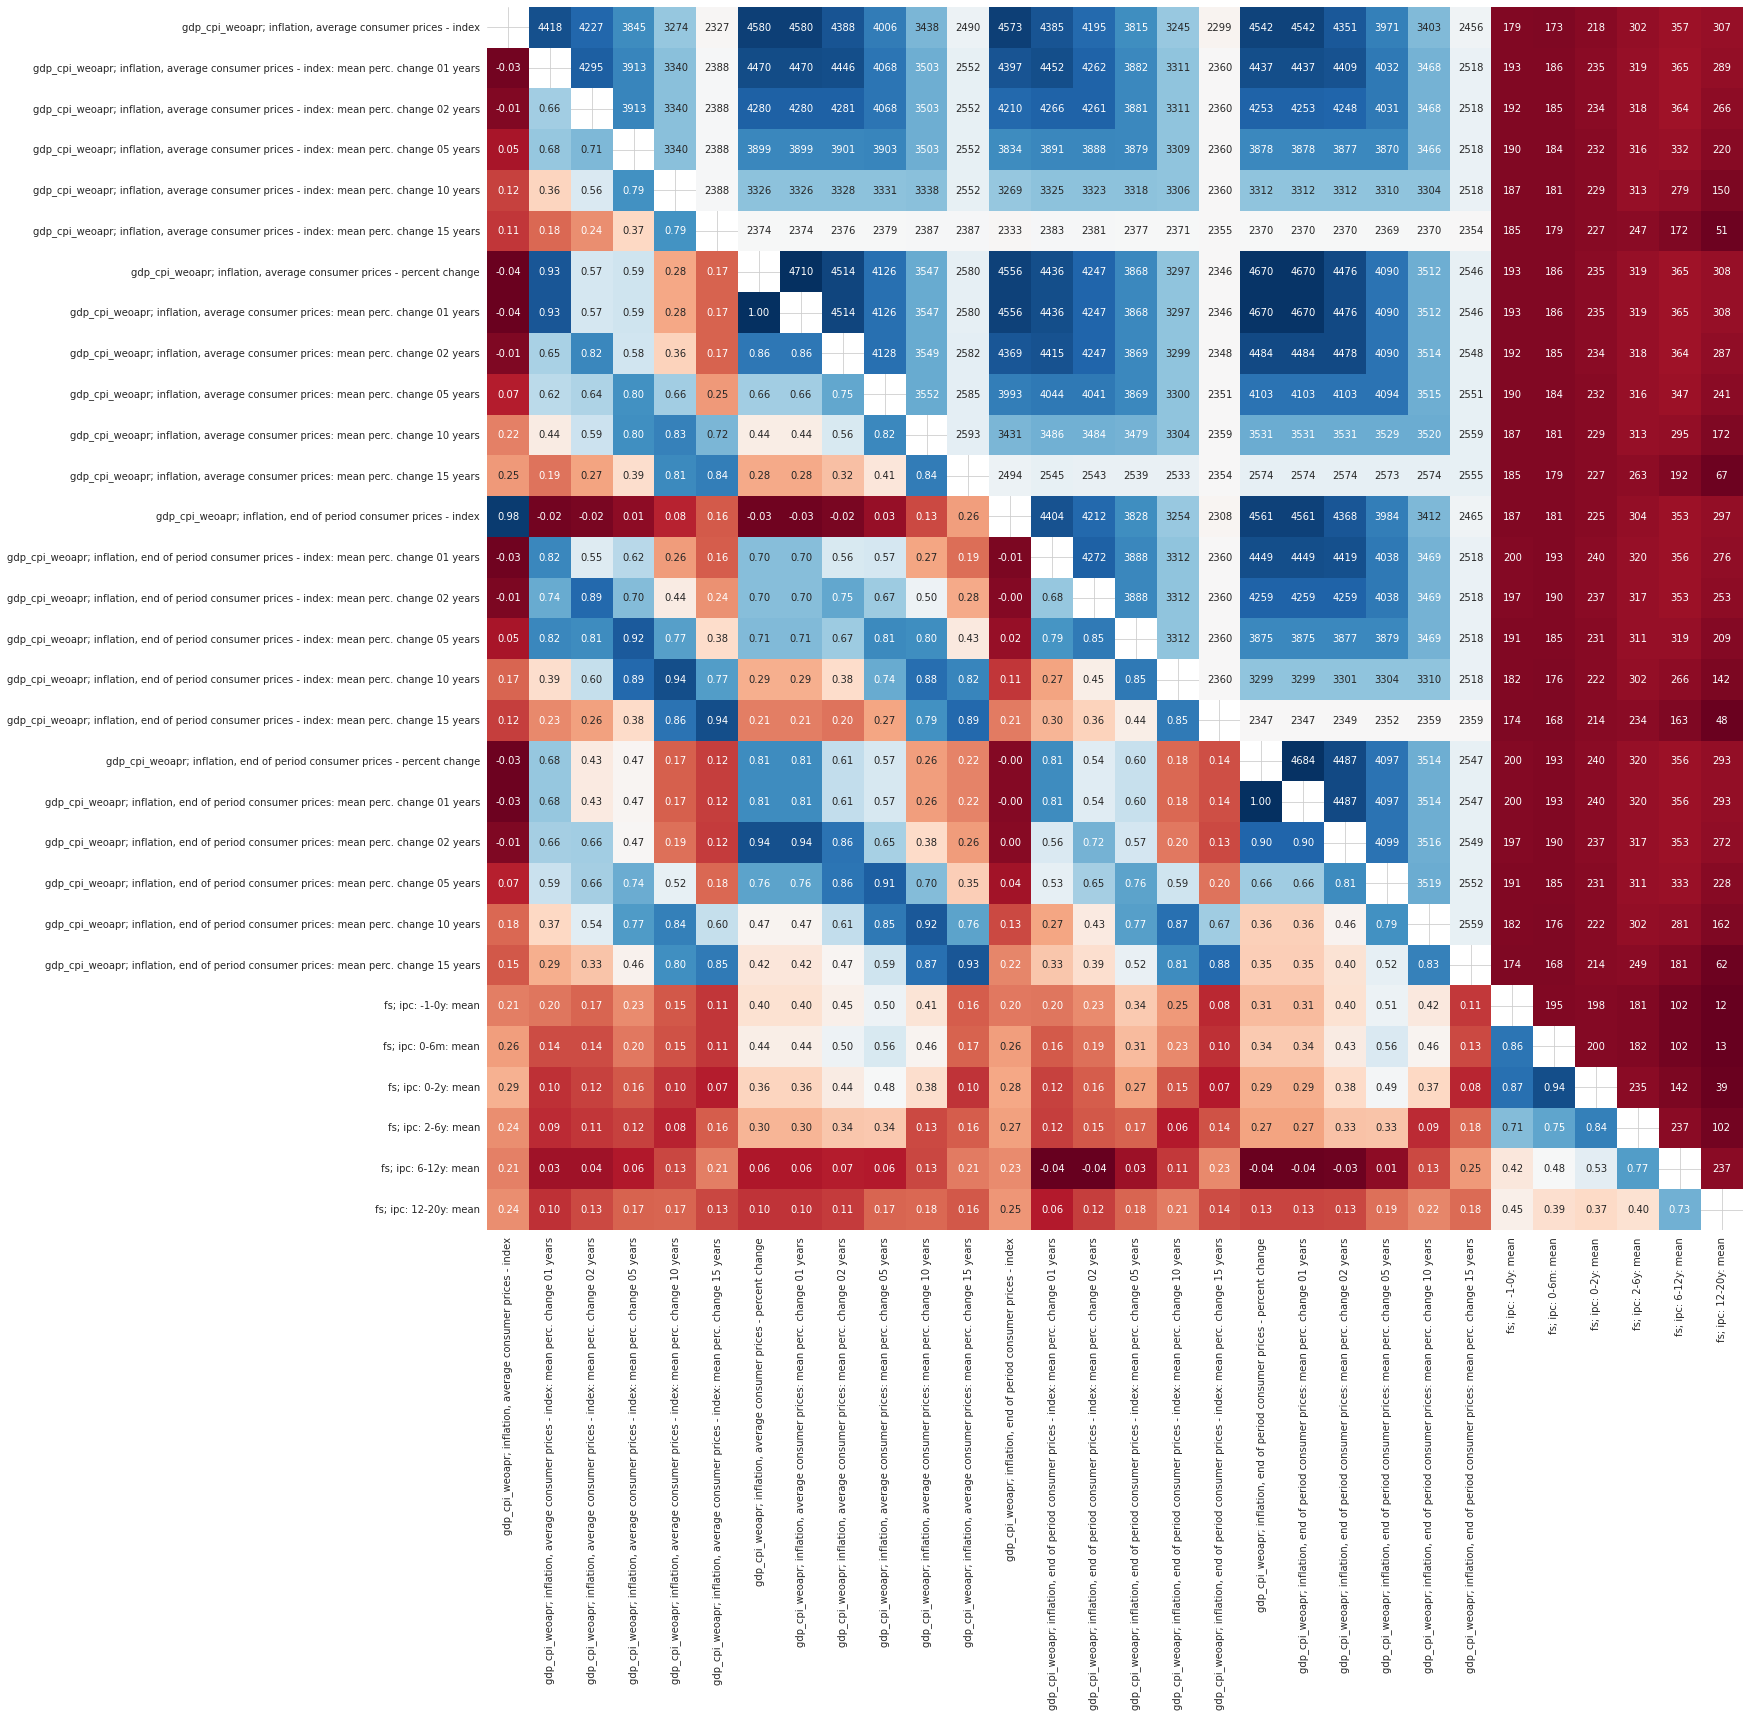

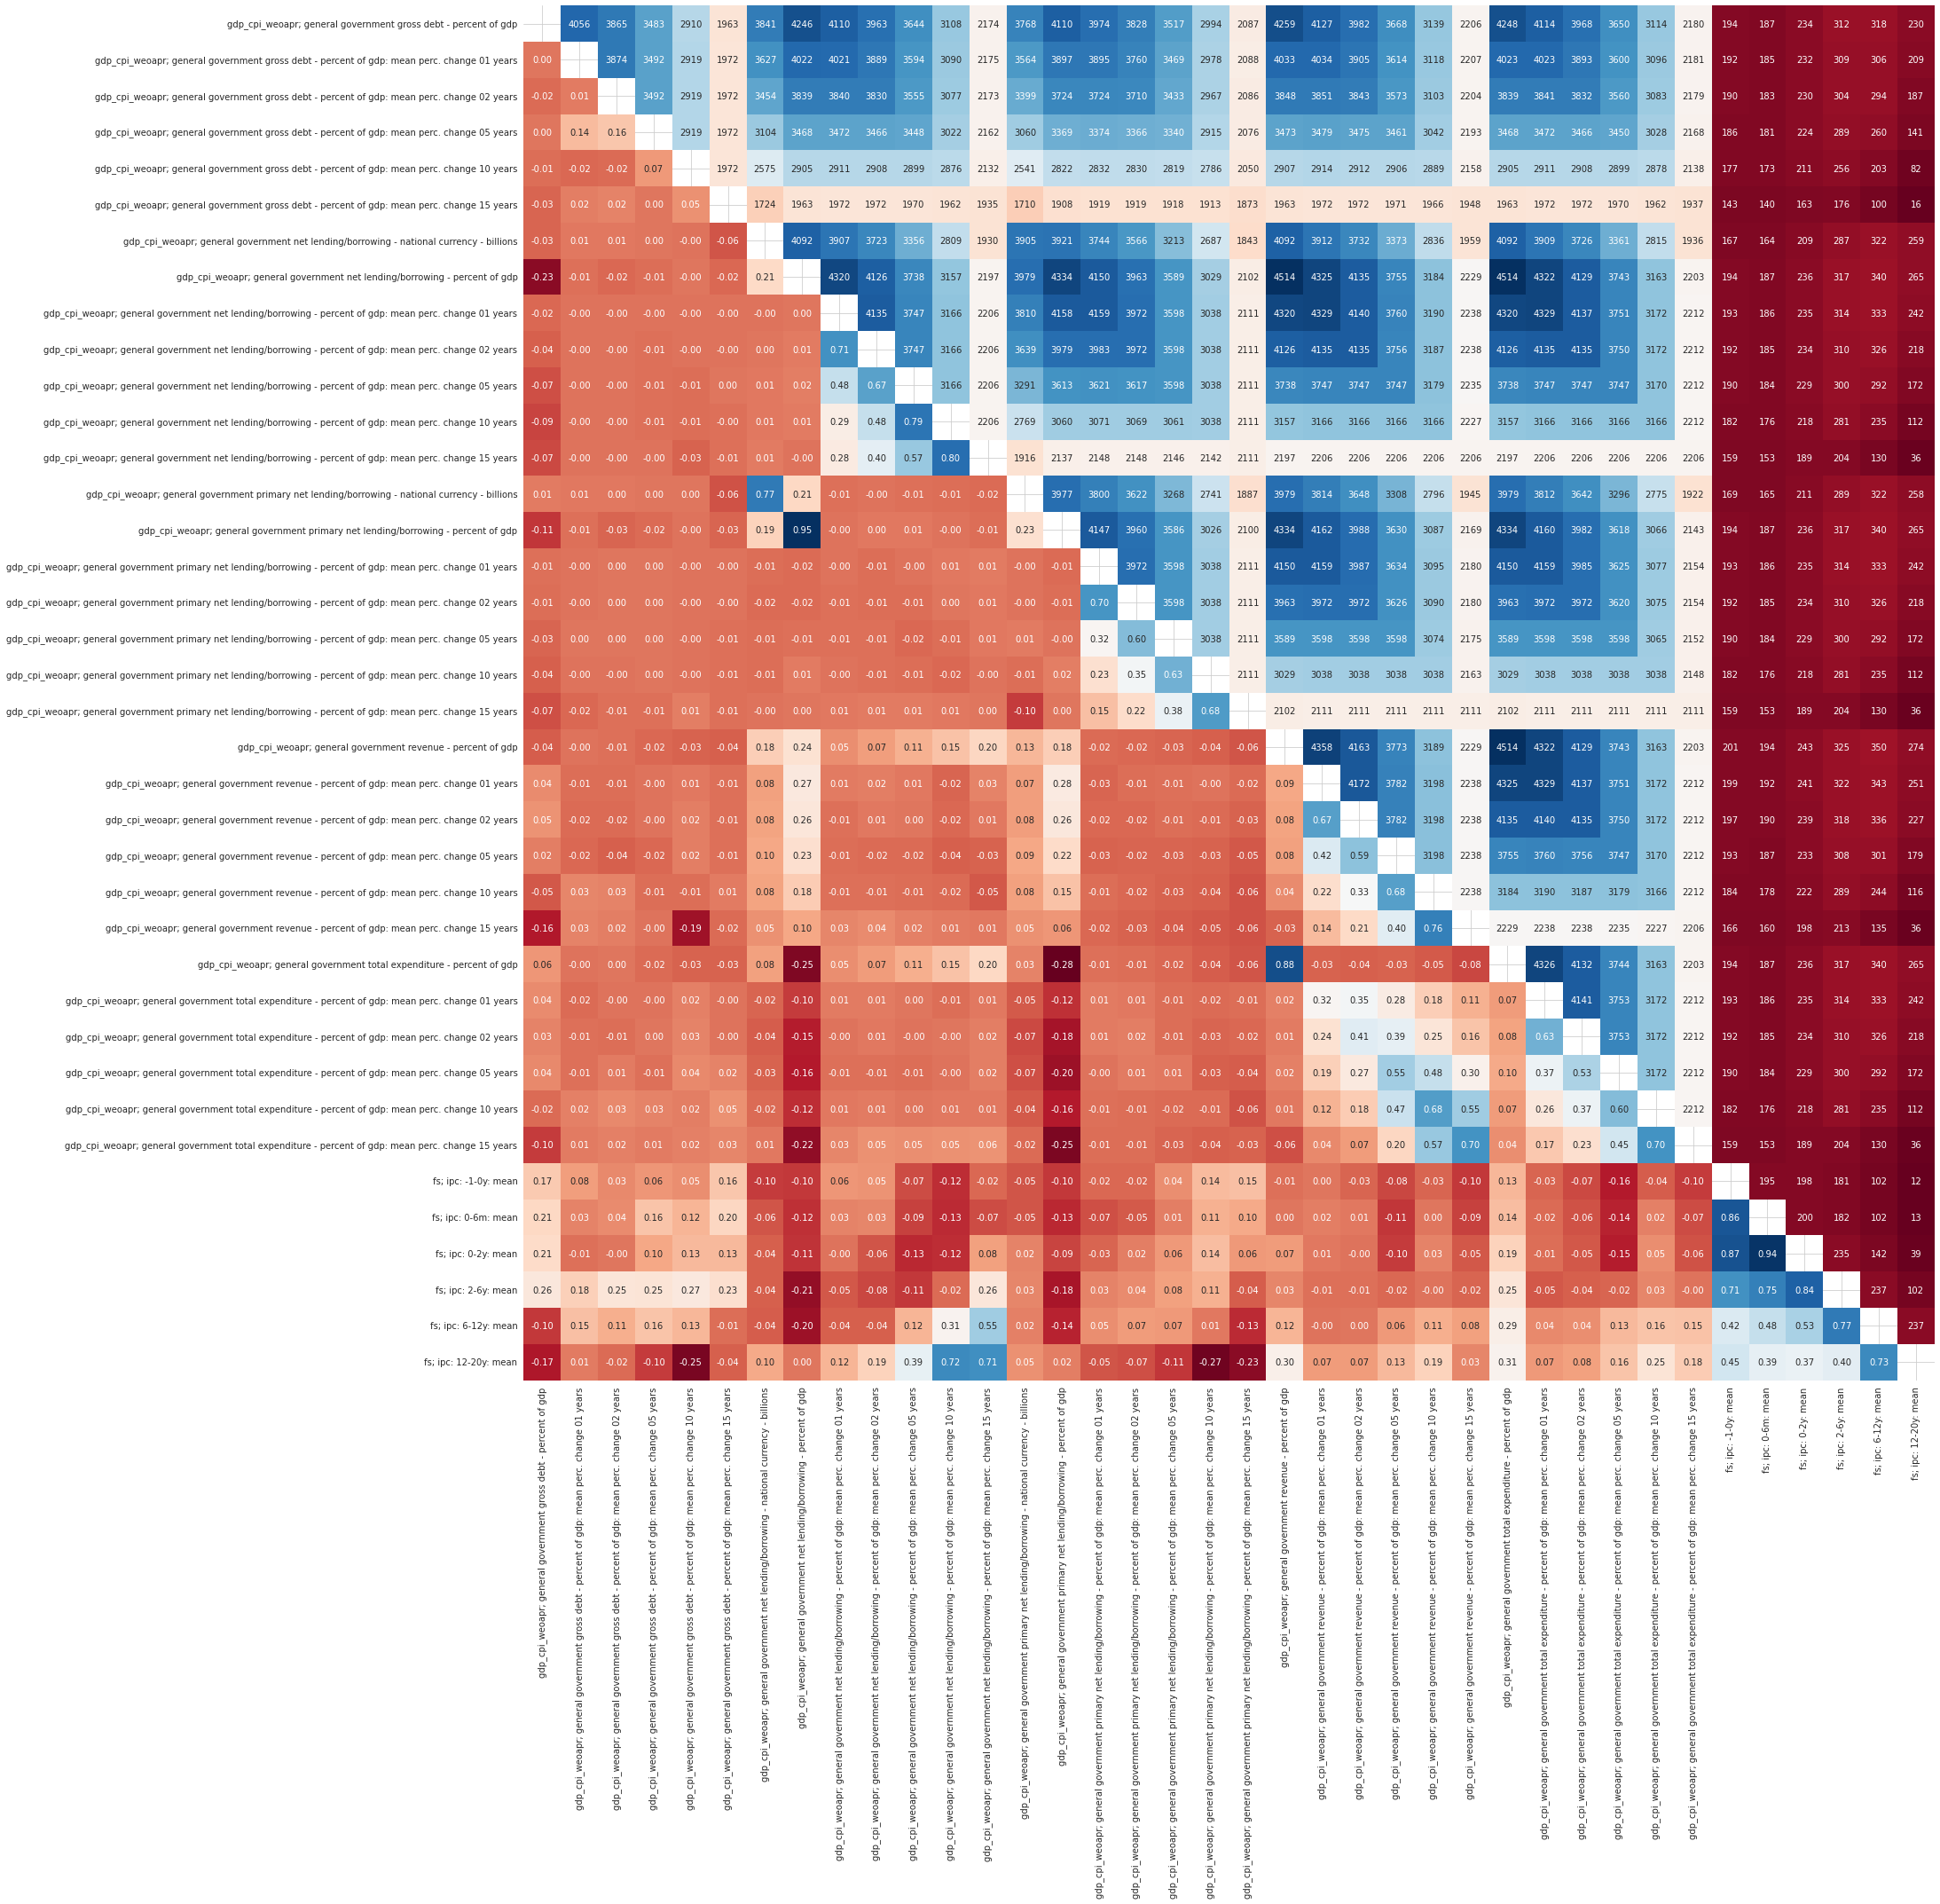

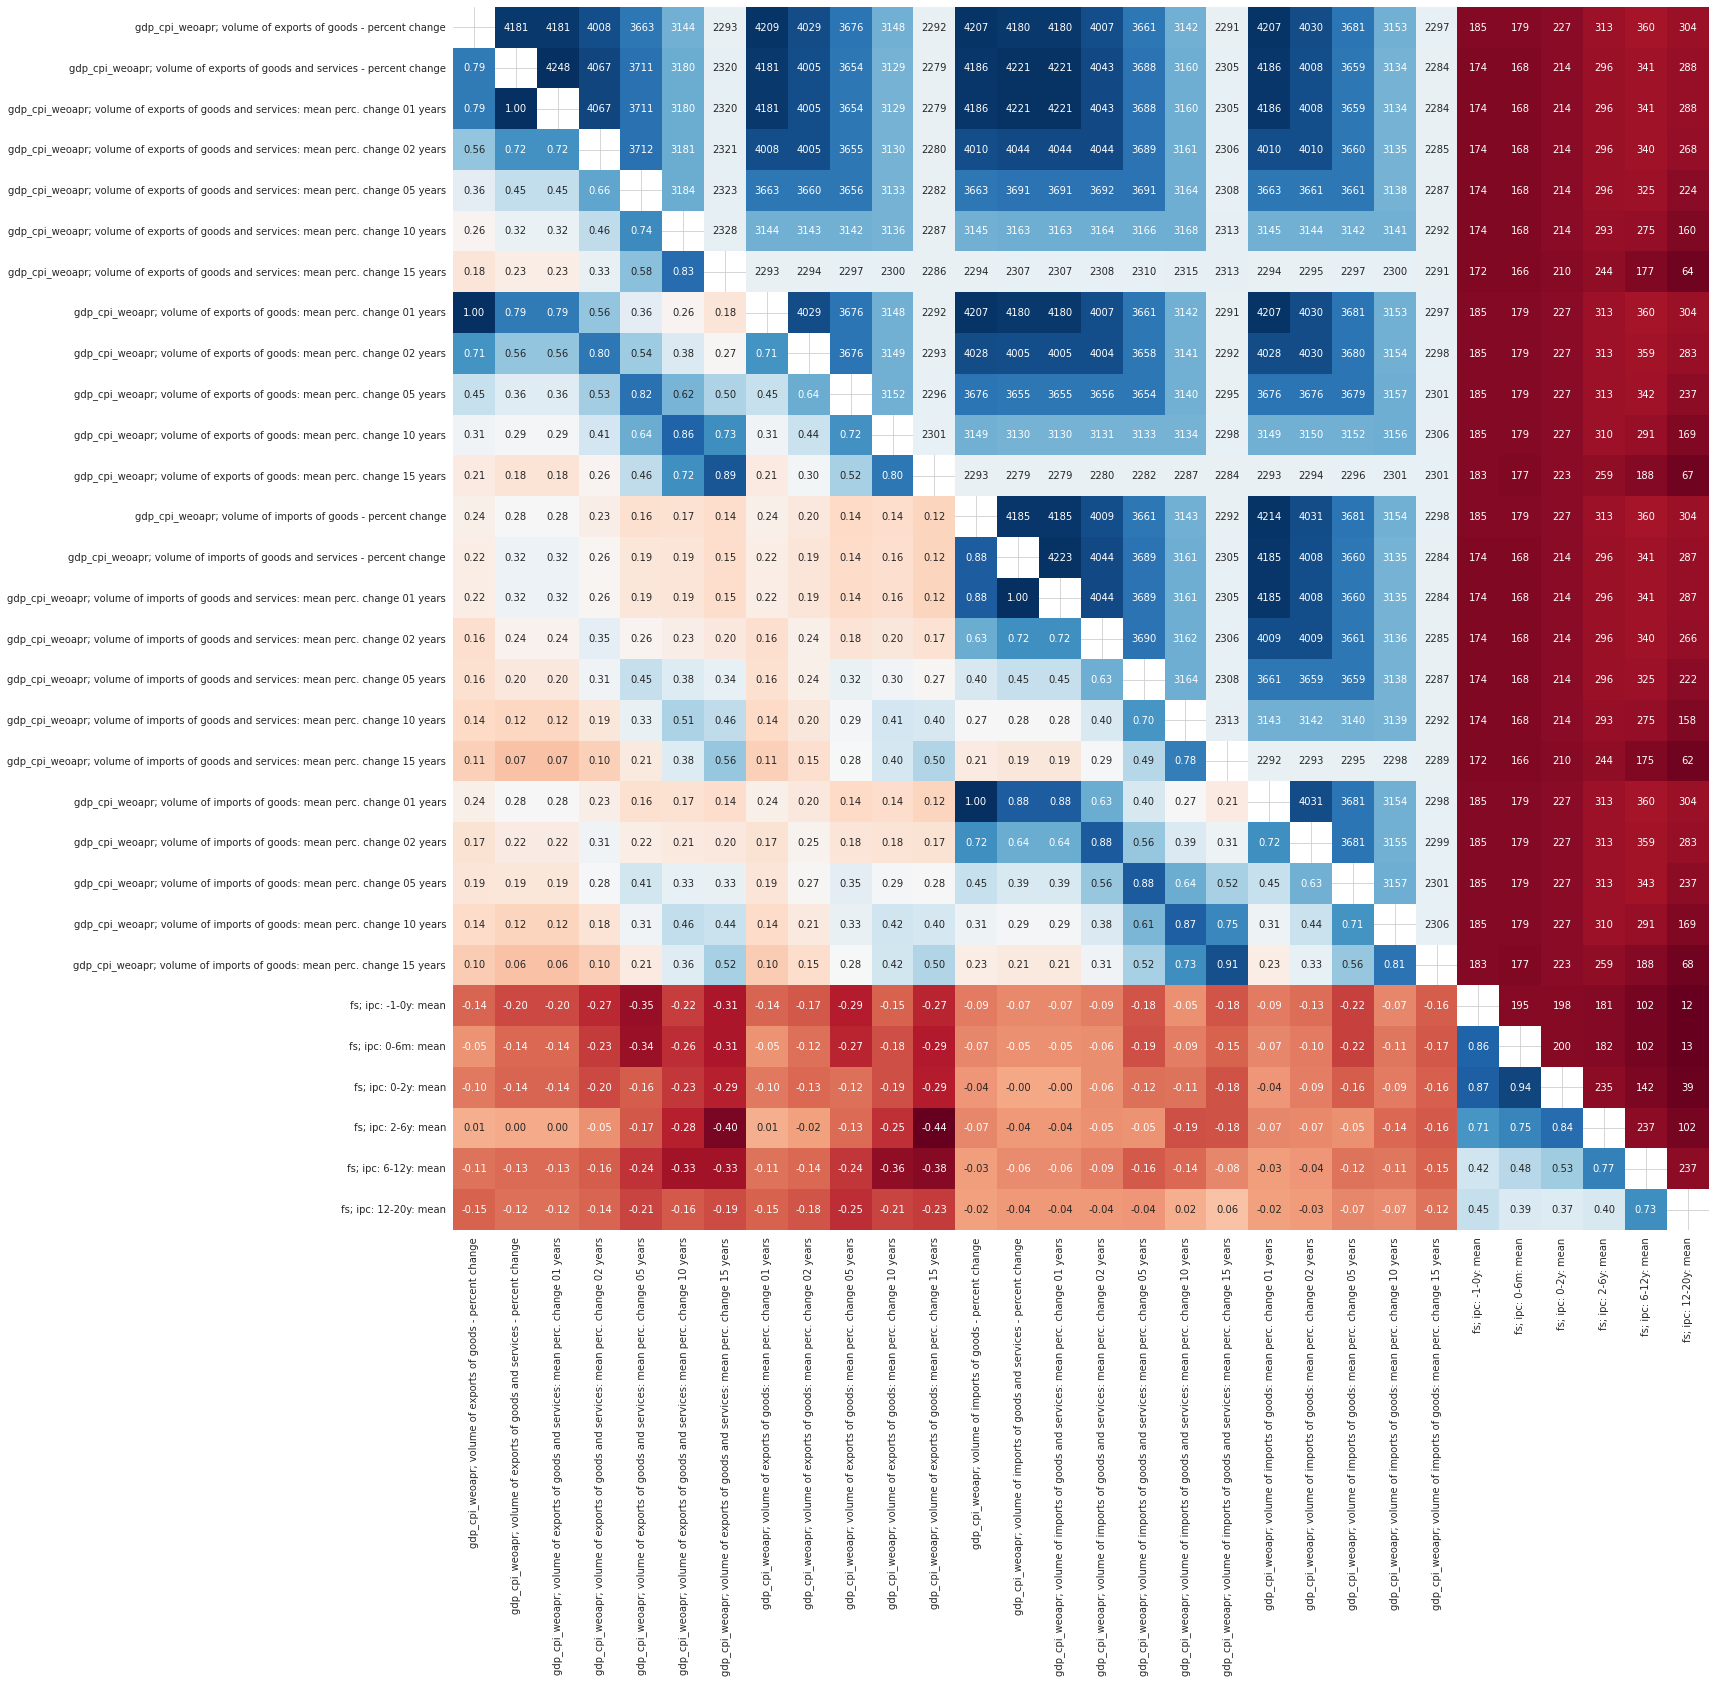

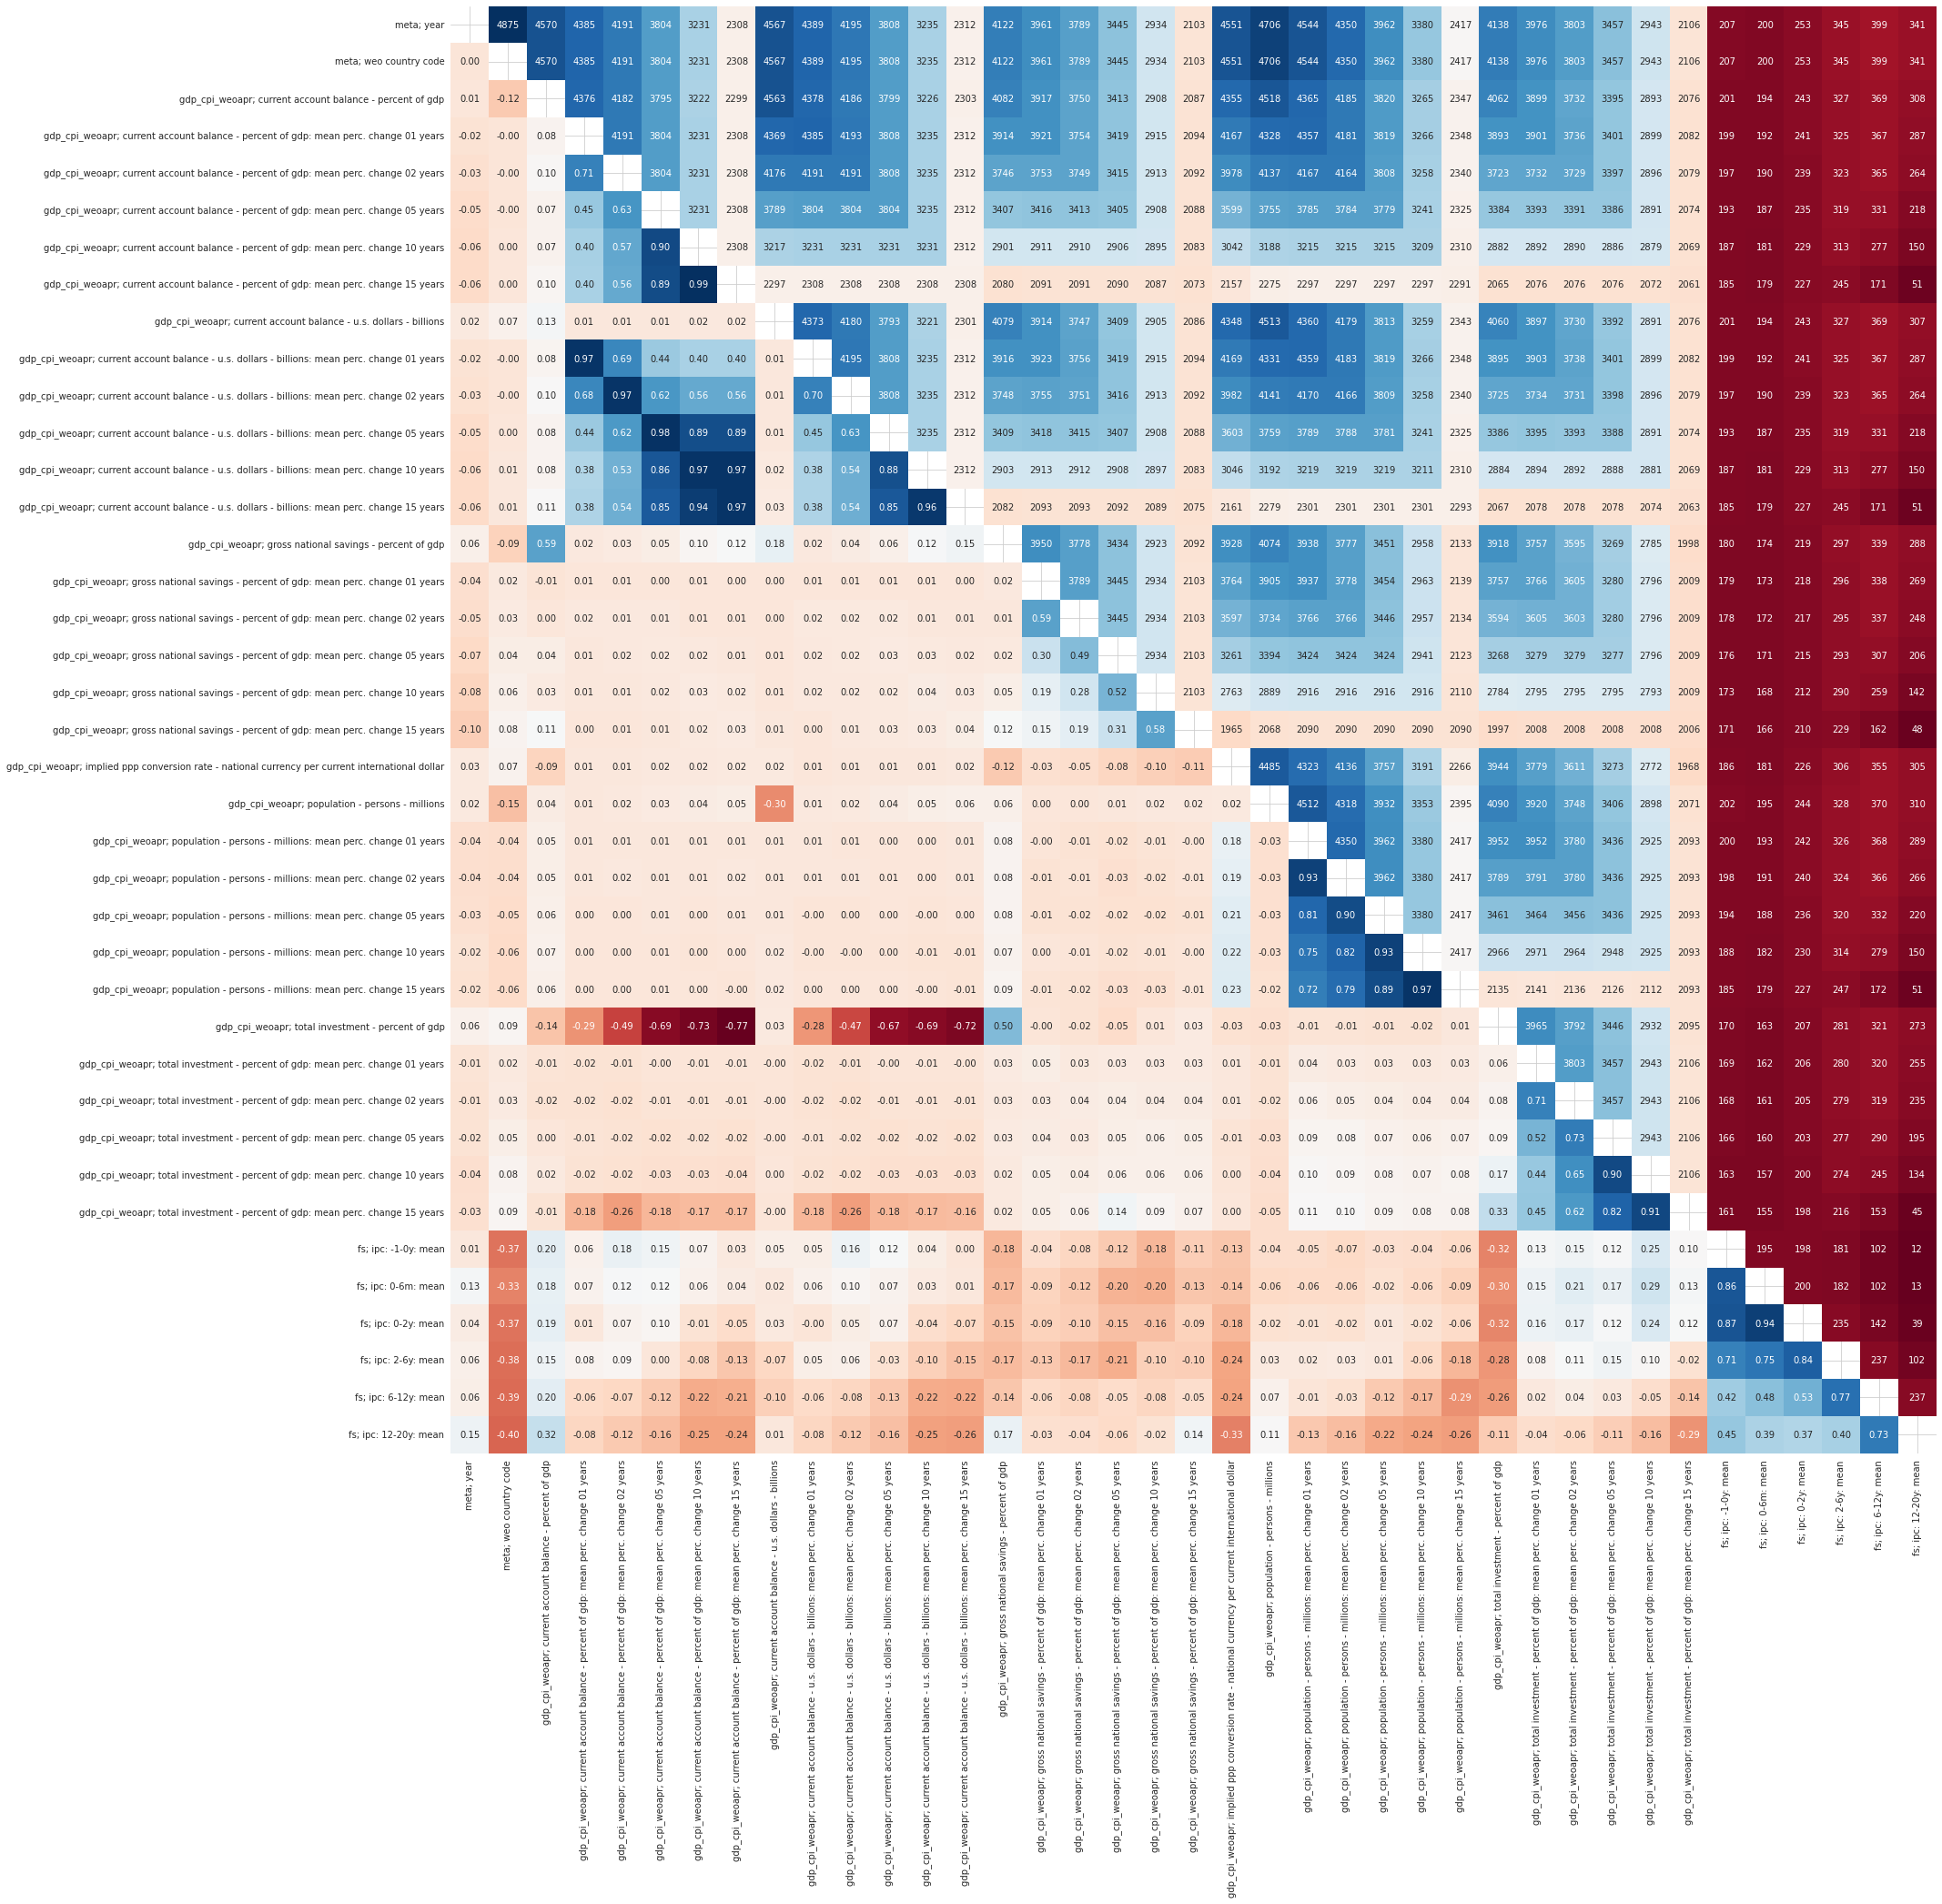

In [13]:
df = df2.copy()
key_words = ['gross domestic product', 'inflation', 'government', 'volume']
fs_cols = [col for col in df.columns if 'fs;' in col and not '0-1y' in col and not '20-30y' in col]
for kw in key_words:
    cols_to_use2 = [col for col in df.columns if kw in col and df[col].count()/df.shape[0]*100 >= min_available_data_per_col]
    create_correlation_matrix(df[cols_to_use2 + fs_cols])
rest_cols = [col for col in df.columns if not any([kw in col for kw in key_words]) and df[col].count()/df.shape[0]*100 >= min_available_data_per_col]
create_correlation_matrix(df[rest_cols + fs_cols].select_dtypes(include=[np.number]))

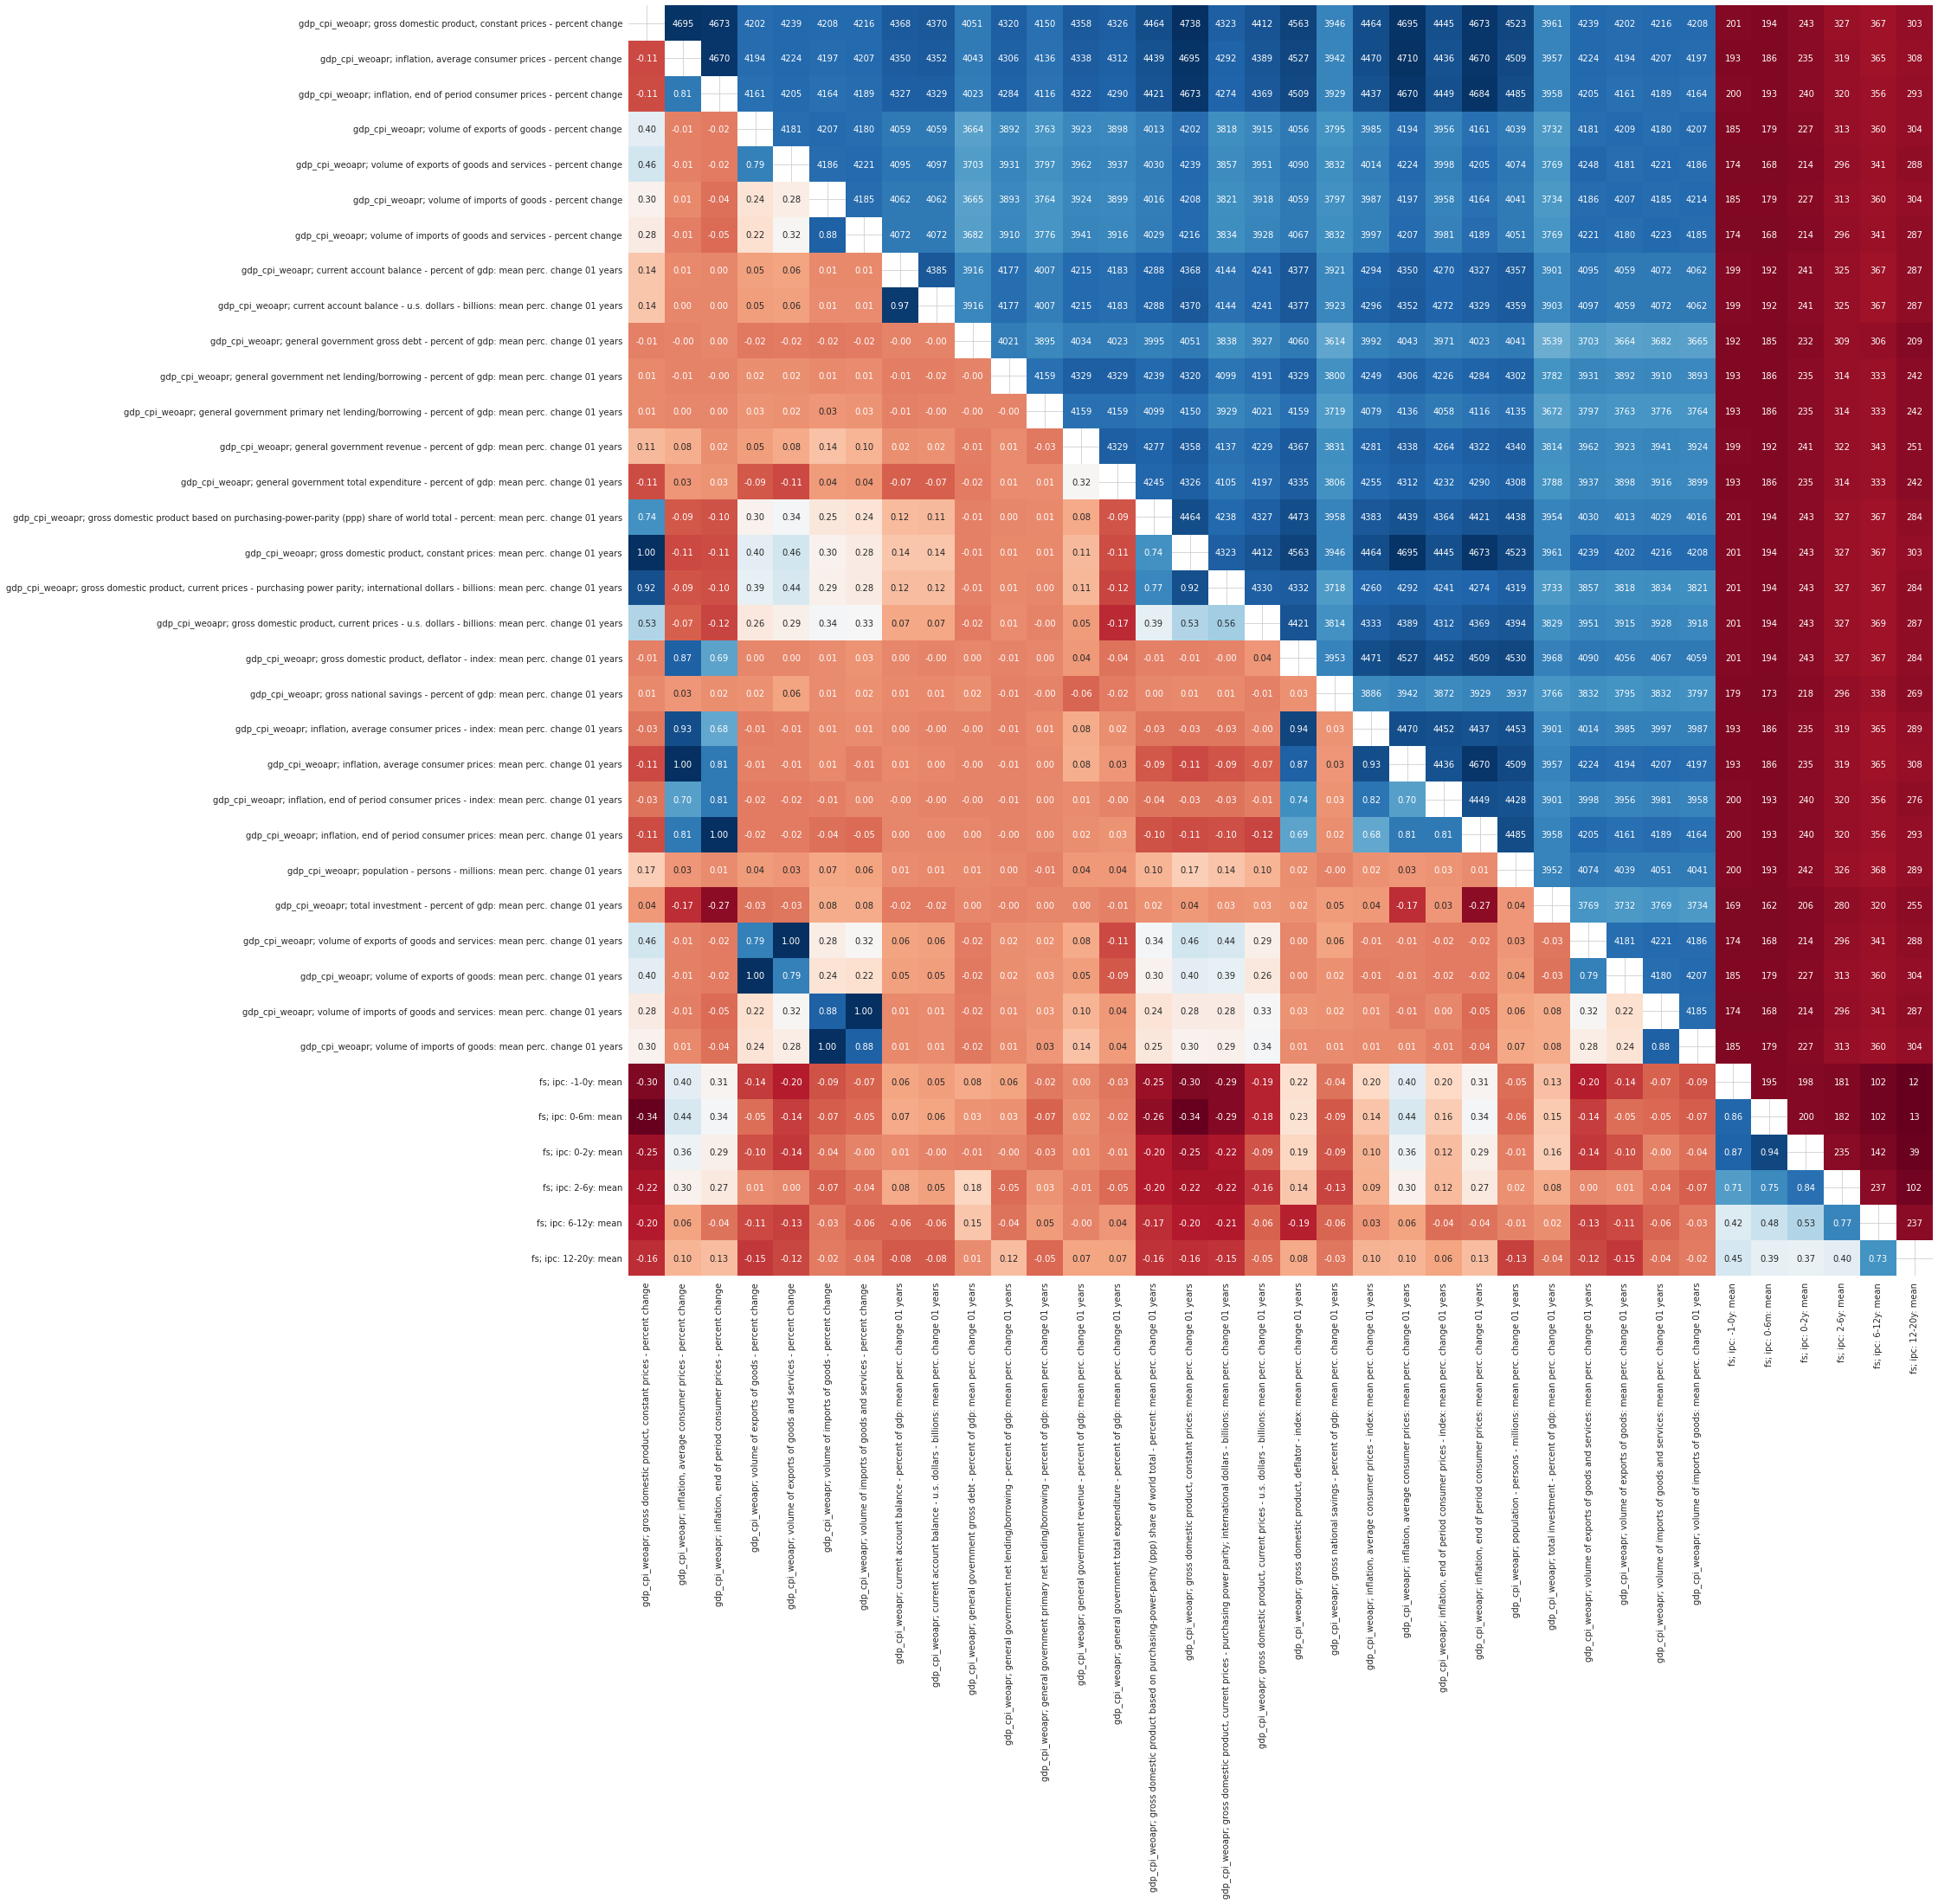

In [14]:
df = df2.copy()
key_words = ['percent change', 'perc. change 01']
# fs_cols = [col for col in df.columns if 'fs;' in col and not '0-1y' in col and not '20-30y' in col]
cols_to_use2 = []
for kw in key_words:
    cols_to_use2.extend([col for col in df.columns if kw in col and df[col].count()/df.shape[0]*100 >= min_available_data_per_col])
create_correlation_matrix(df[cols_to_use2 + fs_cols])



In [20]:
df = df[[c for c in df.columns if not 'percent change' in c]]
rename_d = {c: c.replace('meta;', 'Meta;') for c in df.columns if 'meta;' in c}
rename_d_fs = {c: c.replace('fs; ipc', 'FS; IPC') for c in df.columns if 'fs; ipc' in c}
rename_d.update(rename_d_fs)
df = df.rename(columns=rename_d)
df = df.rename(columns={'Meta; adm0_name': 'Meta; adm0_gaul'})
for col in df.columns:
    try:
        print(col, round(df[df['FS; IPC: 0-6m: mean'].notna()][col].count()/len(df['FS; IPC: 0-6m: mean'].dropna())*100, 2), round(df[[col, 'FS; IPC: 0-6m: mean']].corr().iloc[0, 1] * 100, 2))
    except ValueError:
        print(col, df[col].count()/df.shape[0]*100)
        

Meta; iso 100.0
Meta; adm0_gaul 100.0
Meta; year 100.0 12.65
Meta; weo country code 100.0 -32.52
Meta; date 100.0 12.65
gdp_cpi_weoapr; current account balance - percent of gdp 97.0 18.0
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 01 years 96.0 7.46
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 02 years 95.0 12.0
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 05 years 93.5 11.57
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 10 years 90.5 6.39
gdp_cpi_weoapr; current account balance - percent of gdp: mean perc. change 15 years 89.5 3.65
gdp_cpi_weoapr; current account balance - u.s. dollars - billions 97.0 1.69
gdp_cpi_weoapr; current account balance - u.s. dollars - billions: mean perc. change 01 years 96.0 6.33
gdp_cpi_weoapr; current account balance - u.s. dollars - billions: mean perc. change 02 years 95.0 9.61
gdp_cpi_weoapr; current account balance - u.s. dollar

In [19]:
df.to_csv(out_f, index=False)